# Model explainability study on ImRex

## Libraries import

In [1]:
%matplotlib inline 

# base libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as P
import numpy as np
import tensorflow as tf
import pandas as pd

# misc
import json as js
import PIL.Image
import saliency.core as saliency
from sklearn import preprocessing
import os
import pickle as pkl

# bio data management
from Bio.PDB import PDBParser, Selection
from Bio.Data.IUPACData import protein_letters_3to1
from Bio import Align

# web scraping soup
from bs4 import BeautifulSoup
import requests
import urllib.request 

# web scraping selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait       
from selenium.webdriver.common.by import By       
from selenium.webdriver.support import expected_conditions as EC
import time
import os
from zipfile import ZipFile

# ttest
import scipy.stats

#### Run the model to generate the predictions

In [2]:
# Components of the command string:
# 1) path to the ImRex's predict.py script 
# 2) --model followed by the path to the pretrained ImRex model
# 3) --input followed by the path to the input sequences
# 4) --ouput followed by the path where to save the output
# 5) --images_dir followed by path to the directory where to save the generated property maps

 
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/input-sequences.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-predictions.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/


2021-08-21 15:29:27,485 - root - INFO - CLI argument batch_size: 128
2021-08-21 15:29:27,485 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-21 15:29:27,485 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-21 15:29:27,485 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-21 15:29:27,485 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/'
2021-08-21 15:29:27,486 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/input-sequences.csv'
2021-08-21 15:29:27,486 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-21 15:29:27,486 - root - INFO - CLI argument max_length_epitope: 11
2021-08-21 15:29:27,486 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-21 15:29:27,486 - root - INFO - CLI argument min_length_epitope: 8
2021-08-21 15:29:27,486 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-0

In [3]:
# import of the model object and some directories
model = tf.keras.models.load_model("/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5")
# directory where the generated property maps will the saved by predict.py
img_path = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/'
work_dir = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/'

In [4]:
# load images saved with pickle during the execution predict.py
pickles = []
for f in sorted(os.listdir(img_path)):
    try:
        with open(img_path+f,'rb') as fil:
            x = pkl.load(fil)
            pickles.append(x)
    except:
        pass
        
pickles = tf.convert_to_tensor(pickles) # conversion to tensor of the list
pickles = tf.cast(pickles, tf.float32) # cast to float
pickles.shape # [number of images, 20, 11, 4]

TensorShape([9, 20, 11, 4])

In [5]:
# function to determine the prediction for each image given by the model
def predictions(img):
    image_batch = tf.expand_dims(img, 0)
    prob = model(image_batch)
    prediction = tf.math.round(prob)
    return prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


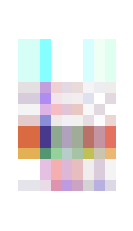

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0


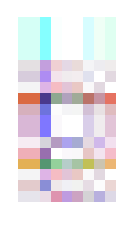

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


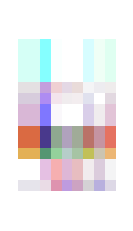

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


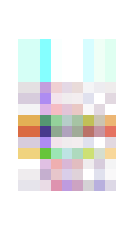

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


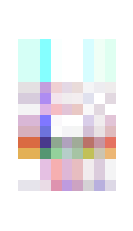

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


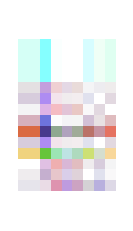

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


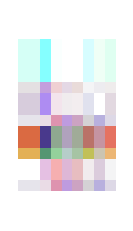

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


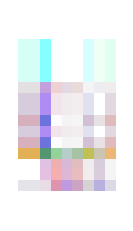

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0


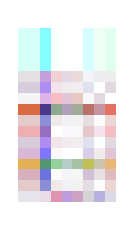

In [6]:
for p in pickles:
    
    prediction = predictions(p)
    prediction = int(prediction.numpy())
    print('Prediction: ' + str(prediction))
    
    plt.imshow(p)
    plt.axis('off')
    plt.show()

## Integrated Gradients: from scratch implementation
###### [From the TensorFlow documentation](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

Integrated Gradients aim to accumulate pixel local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability.

Required steps:

1) interpolate small steps along a straight line in the feature space between a baseline and the input pixel's value

2) compute gradients at each step between the model's predictions with respect to each step

3) approximate the integral between the baseline and input by accumulating these local gradients.


A baseline is an input image used as a starting point for calculating feature importance (it represents the impact of the absence of each pixel prediction to contrast with its impact of each pixel on the prediction when present in the input image). The choice of the baseline has therefore high impact on the visualization of the feature's importance.

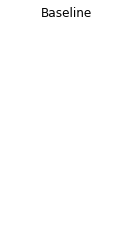

In [7]:
# definition of the baseline
baseline = tf.zeros(shape=(20,11,4)) # Baseline for CMYK format. The picture is white in this 4-channel case
                                     # It will stay the baseline for the remainder of the notebook
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Linear interpolation path between baseline and input images at alpha intervals

In [8]:
m_steps=40 # number of interpolation steps chosen
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # levels of transparency for each step

In [9]:
# fuction to generate the linear interpolations
def generate_path_inputs(baseline,
                         input,
                         alphas):
  # Expand dimensions for vectorized computation of interpolations.
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(input, axis=0) 
    delta = input_x - baseline_x
    path_inputs = baseline_x +  alphas_x * delta
  
    return path_inputs

In [10]:
# generate the interpolated images
path_inputs = generate_path_inputs(
    baseline=baseline, 
    input=pickles[0],
    alphas=alphas)

path_inputs.shape # [number of steps + 1, 20, 11, 4]

TensorShape([41, 20, 11, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


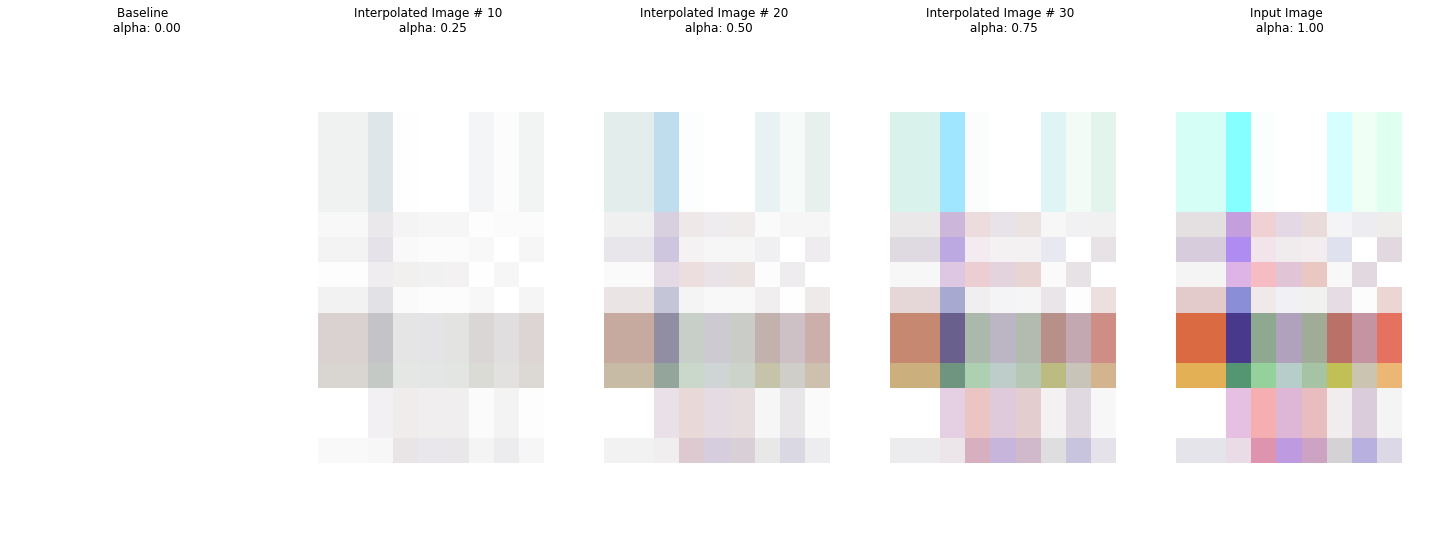

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(20, 11))

axs[0,0].set_title('Baseline \n alpha: {:.2f}'.format(alphas[0]))
axs[0,0].imshow(path_inputs[0])
axs[0,0].axis('off')

axs[0,1].set_title('Interpolated Image # 10 \n alpha: {:.2f}'.format(alphas[10]))
axs[0,1].imshow(path_inputs[10])
axs[0,1].axis('off')

axs[0,2].set_title('Interpolated Image # 20 \n alpha: {:.2f}'.format(alphas[20]))
axs[0,2].imshow(path_inputs[20])
axs[0,2].axis('off')

axs[0,3].set_title('Interpolated Image # 30 \n alpha: {:.2f}'.format(alphas[30]))
axs[0,3].imshow(path_inputs[30])
axs[0,3].axis('off')

axs[0,4].set_title('Input Image \n alpha: {:.2f}'.format(alphas[-1]))
axs[0,4].imshow(path_inputs[-1])
axs[0,4].axis('off')

plt.tight_layout()

###  Gradients computation:
#### Measures the relationship between changes to a feature and changes in the model's predictions, thus identifying which pixels have the strongest effect on the models predicted class probabilities.

In [12]:
# function to compute gradients
import math
def compute_gradients(model, path_inputs):

    with tf.GradientTape() as tape:
        tape.watch(path_inputs) # define on what to calculate the gradients
        outputs = model(path_inputs)
        
    # gradients calculated between probabilities for the target class 
    # on each interpolated image with respect to each interpolated input
    gradients = tape.gradient(outputs, path_inputs)
    
    return gradients

In [13]:
# Let's calculate the gradients for each image along the interpolation path with respect to the correct output
path_gradients = compute_gradients(
    model=model, 
    path_inputs=path_inputs)
path_gradients.shape

TensorShape([41, 20, 11, 4])

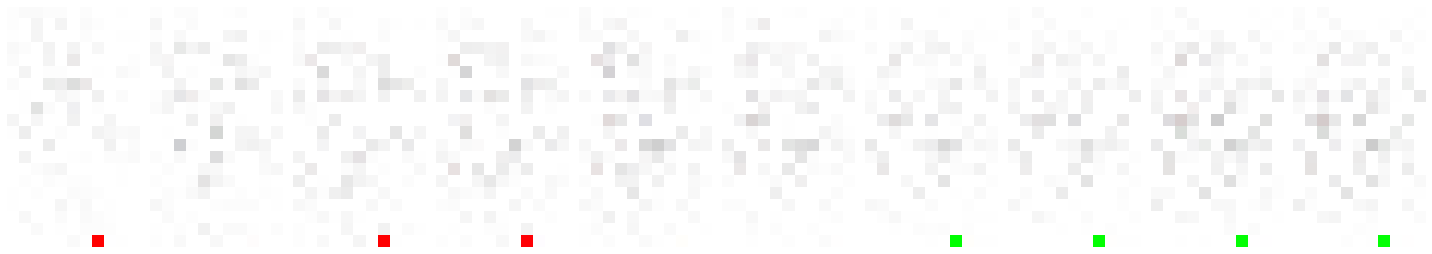

In [14]:
# plot of some of the gradients calculated
fig, axs = plt.subplots(nrows=1, ncols=10, squeeze=False, figsize=(20, 11))
for i in range(10):
    axs[0,i].imshow(tf.cast(255 * path_gradients[i*4], tf.uint8), cmap=plt.cm.viridis)
    axs[0,i].axis('off')
plt.tight_layout()

### Integral approximation:
#### Solves the problem of discontinuous gradient feature importances by taking small steps in the feature space to compute local gradients between predictions and inputs across the feature space and then averages these gradients together to produce feature attributions.

In [15]:
def integral_approximation(gradients, 
                           method='riemann_trapezoidal'):

    # different ways to compute the numeric approximation with different tradeoffs
    # riemann trapezoidal usually the most accurate
    if method == 'riemann_trapezoidal':  
        grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    elif method == 'riemann_left':
        grads = gradients
    elif method == 'riemann_midpoint':
        grads = gradients
    elif method == 'riemann_right':    
        grads = gradients
    else:
        raise AssertionError("Provided Riemann approximation method is not valid.")

    # average integration approximation
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)


    return integrated_gradients

In [16]:
ig = integral_approximation(
    gradients=path_gradients,
    method='riemann_trapezoidal')

### Attributions visualization

In [17]:
def plot_img_attributions(baseline,
                          image,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = (image - baseline) * ig

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


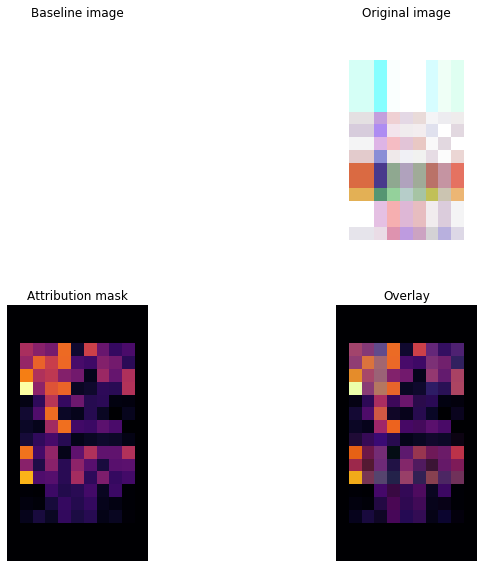

In [18]:
_ = plot_img_attributions(image=pickles[0],
                          baseline=baseline,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

## Integrated Gradients: saliency maps implementation
##### [From the library on GitHub](https://github.com/PAIR-code/saliency)

In [19]:
# Some functions to plot the masks and the images
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

In [20]:
class_idx_str = 'class_idx_str'
# definition of the function to compute the gradients, it will be passed to the various saliency techniques functions
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
            tape.watch(images)
            output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preditiction: 1


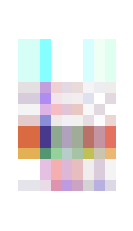

In [21]:
# Load the first image that will be used to showcase the implementations
im = pickles[0]

# Show the image
ShowImage(im)

prediction = predictions(im)
prediction = int(prediction.numpy())
print('Preditiction: ' + str(prediction))
call_model_args = {class_idx_str: prediction}

In [22]:
# Initialize the saliency objects
gradient_saliency = saliency.GradientSaliency() # Vanilla Gradients
integrated_gradients = saliency.IntegratedGradients() # Vanilla Integrated Gradients
guided_ig = saliency.GuidedIG() # Guided Integrated Gradients
xrai_object = saliency.XRAI() # XRAI
blur_ig = saliency.BlurIG() # Blur Integrated Gradients


# Visualization parameters
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 15

In [23]:
# Compute masks for different techniques
# (some of them will take a while due to the high amount of computations required)
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args) # Vanilla Gradients

smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args) # SmoothGrad

vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20) # Vanilla IG

guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5) # Guided IG

smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20) # SmoothGrad IG


blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20) # Blur IG

smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(
    im, call_model_function, call_model_args, batch_size=20) # SmoothGrad Blur IG

In [24]:
# Convert masks to grayscale
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)

smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

vanilla_integrated_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

/Users/fabio_air/anaconda3/lib/python3.8/site-packages/saliency/core/xrai.py:474: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segs = _get_segments_felzenszwalb(x_value)


### Vanilla Gradients vs SmoothGrad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


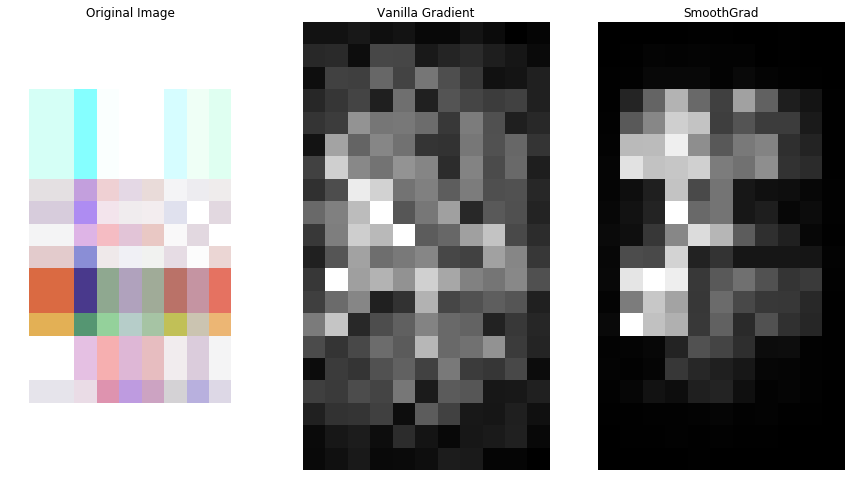

In [25]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs Guided IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


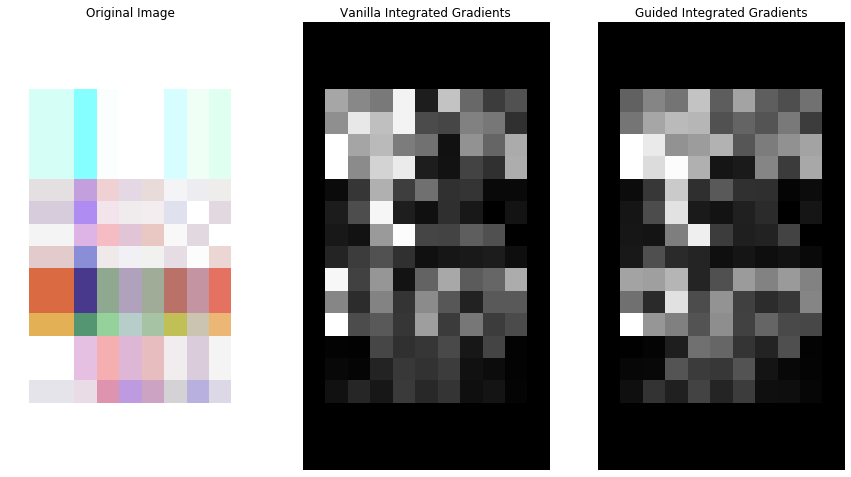

In [26]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs SmoothGrad IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


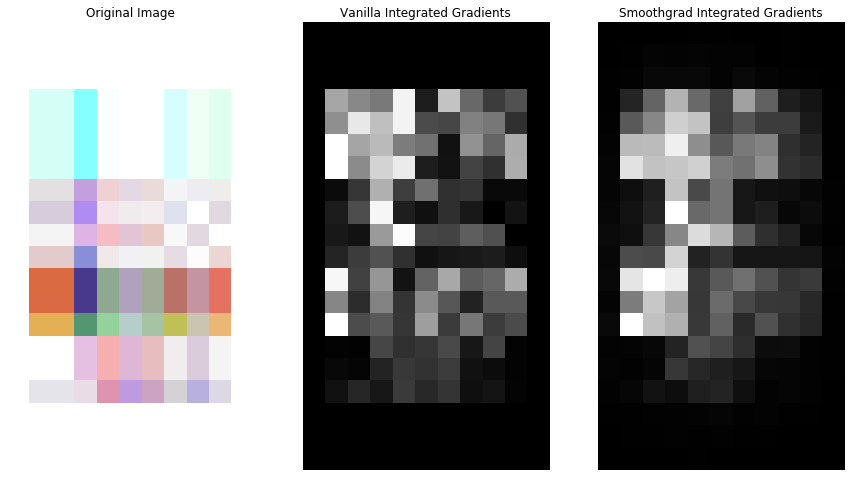

In [27]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### XRAI Attributions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


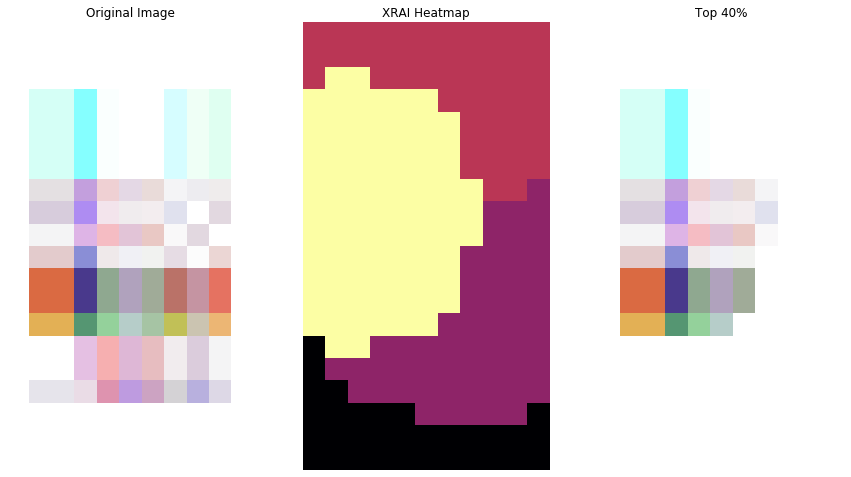

In [28]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Original image
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
# XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Most salient 20% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 60)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 40%', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs Blur IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


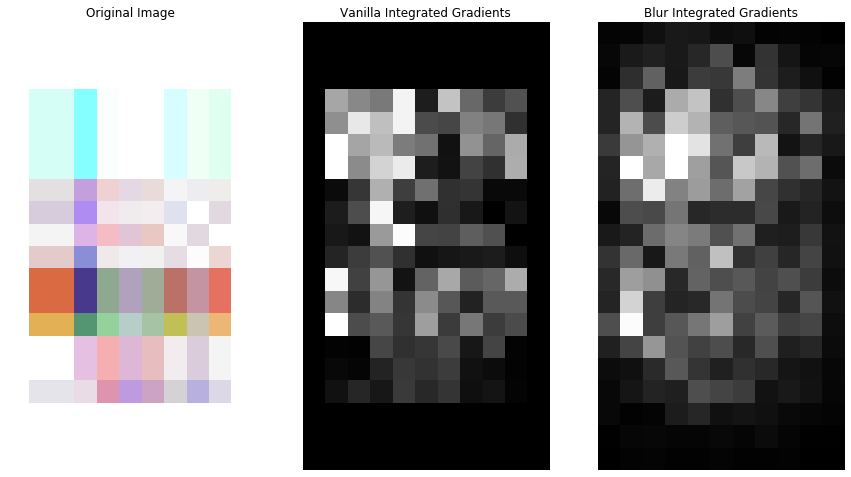

In [29]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Blur IG vs SmoothGrad Blur IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


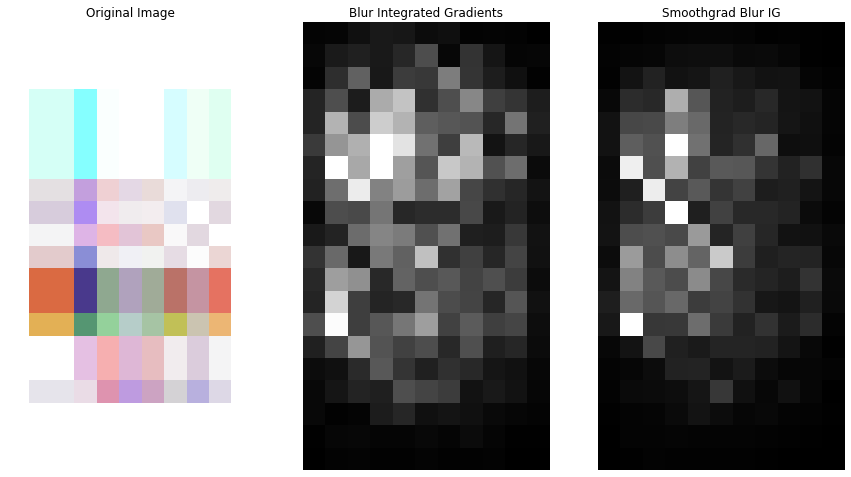

In [30]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='Smoothgrad Blur IG', ax=P.subplot(ROWS, COLS, 3))

### Summary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


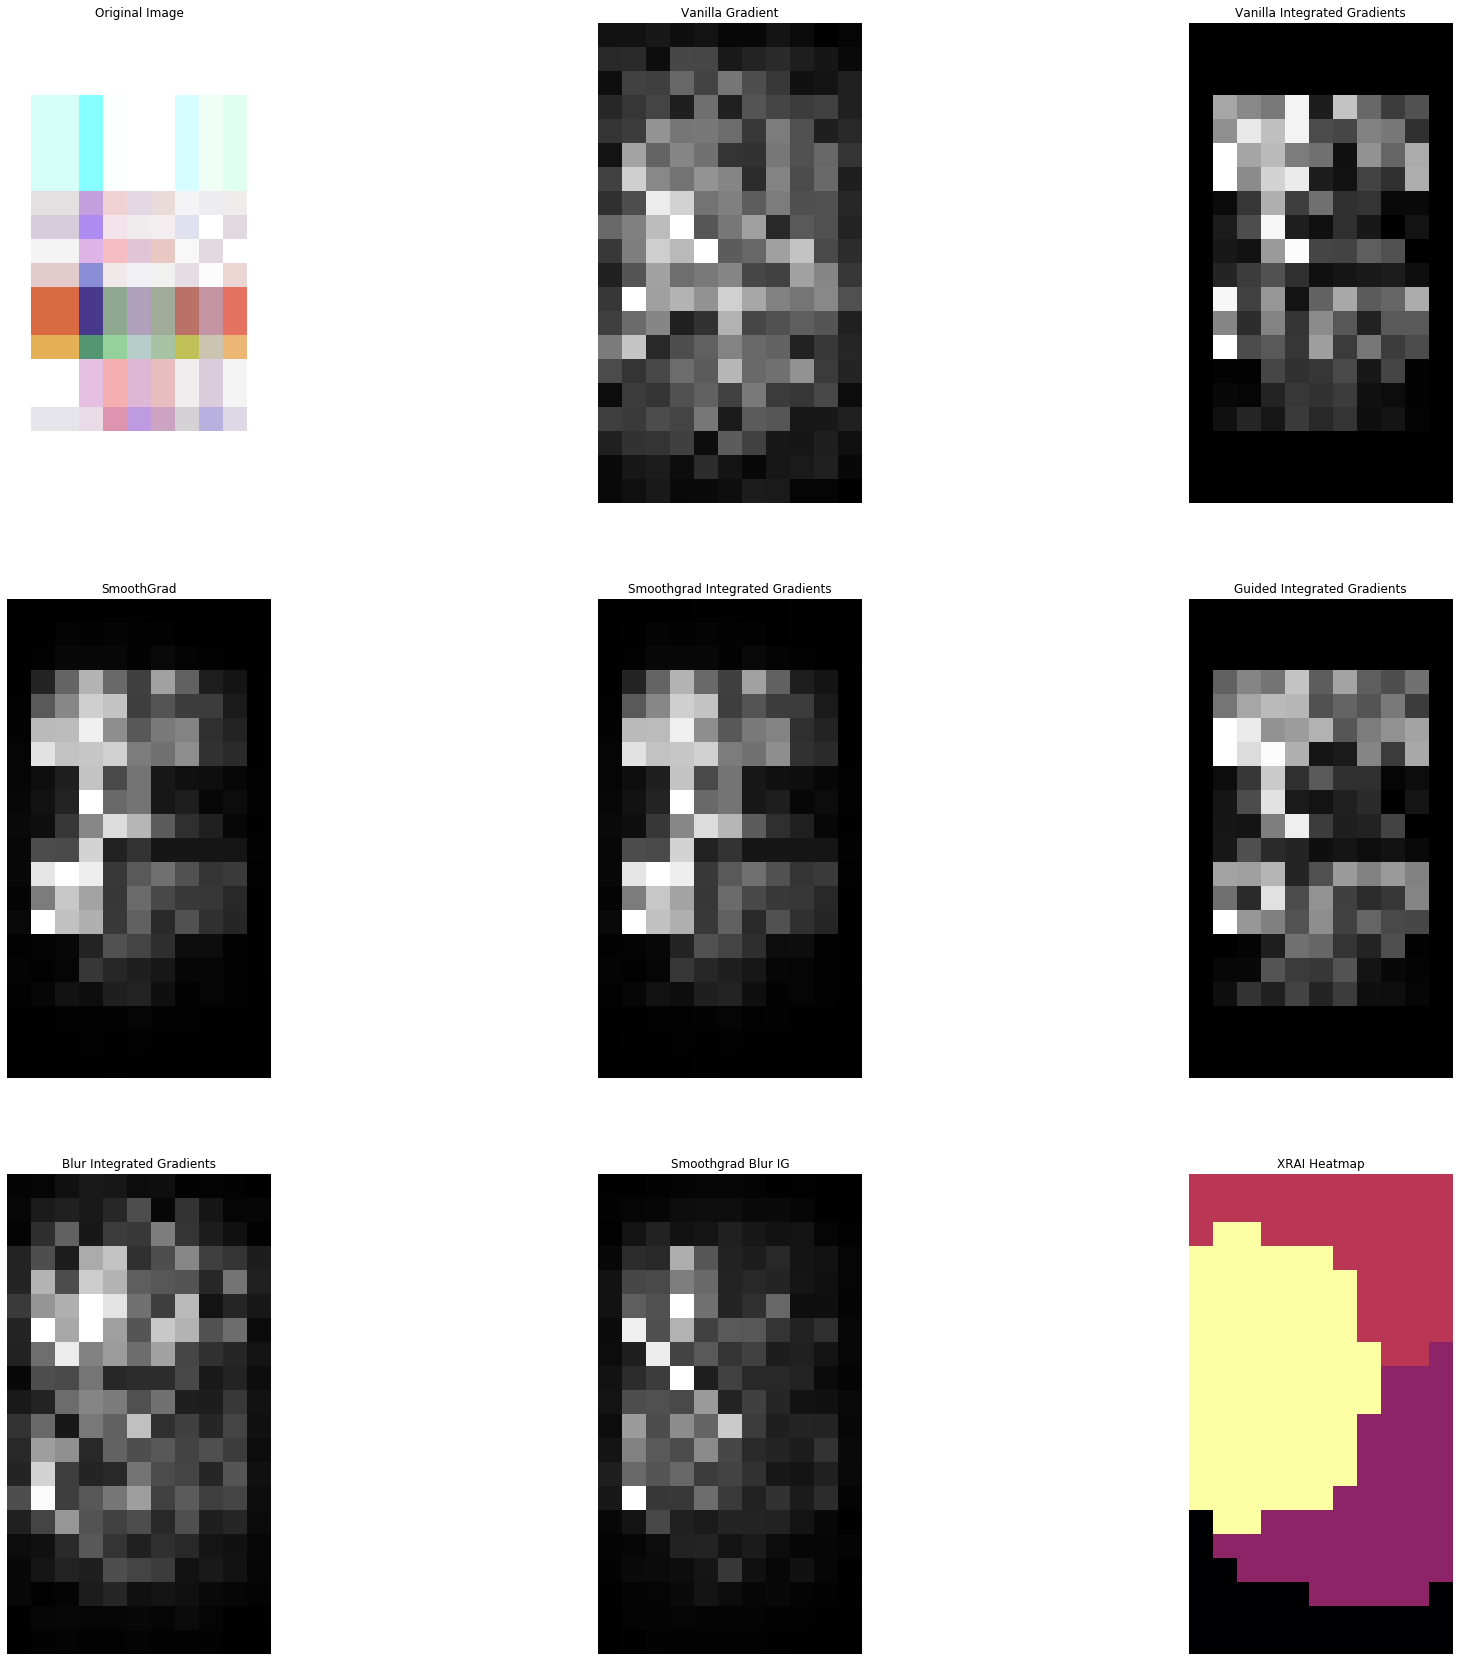

In [31]:
plt.figure(figsize=(3 * 10, 3 * 10))
ShowImage(im, title='Original Image', ax=P.subplot(3, 3, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(3, 3, 2))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(3, 3, 3))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(3, 3, 4))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(3, 3, 5))
ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(3, 3, 6))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(3, 3, 7))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='Smoothgrad Blur IG', ax=P.subplot(3, 3, 8))
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(3, 3, 9))

# CDR3-epitope interaction data exploration

In [32]:
# the command has to be rerun to generate the new images based on the new data
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/preprocessed_vdjdb.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-predictions.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/

2021-08-21 15:30:25,370 - root - INFO - CLI argument batch_size: 128
2021-08-21 15:30:25,371 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-21 15:30:25,372 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-21 15:30:25,372 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-21 15:30:25,372 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/'
2021-08-21 15:30:25,372 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/preprocessed_vdjdb.csv'
2021-08-21 15:30:25,372 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-21 15:30:25,372 - root - INFO - CLI argument max_length_epitope: 11
2021-08-21 15:30:25,372 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-21 15:30:25,372 - root - INFO - CLI argument min_length_epitope: 8
2021-08-21 15:30:25,373 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretr

In [33]:
# a new image path is being declared since the dataset has changed
img_path_analysis = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/'

In [34]:
df = pd.read_csv(work_dir + 'output-predictions.csv')
df = df[df.y != 0] # the cases that are not interations are discarded
df = df[df.prediction_score >= 0.5] # the cases where the model has predicted a non-interaction are discarded (false negatives)
df = df.reset_index(drop=True)
df

,cdr3,antigen.epitope,y,prediction_score,im_name
0,CSVWGTGKTYEQYF,FLKEKGGL,1,0.893772,im_1
1,CSVWGEGRSYEQYF,FLKEKGGL,1,0.958685,im_2
2,CSATILAGVPYGEQYF,FLKEKGGL,1,0.932274,im_3
3,CSASEGTSSYEQYF,FLKEKGGL,1,0.823513,im_4
4,CASSFDREVTGELFF,FLKEKGGL,1,0.937733,im_5
...,...,...,...,...,...
13894,CASVTGSTDTQYF,ELKRKMIYM,1,0.909759,im_20268
13895,CASSDGTAYEQYF,ELKRKMIYM,1,0.862933,im_20269
13896,CASSLARNQPQHF,CVETMCNEY,1,0.672335,im_20270
13897,CASGGADMKTEAFF,CVETMCNEY,1,0.893031,im_20271


In [35]:
# load images saved with pickle from predict.py
pickles_analysis = [] # list of pickled Tensors
for f in df['im_name']:
    try:
        with open(img_path_analysis + str(f)+'.pkl','rb') as fil:
            x = pkl.load(fil)
            pickles_analysis.append(x)
    except Exception as e:
        print(e)
        
pickles_analysis = tf.convert_to_tensor(pickles_analysis) # conversion to tensor of the list
pickles_analysis = tf.cast(pickles_analysis, tf.float32) # cast to float
pickles_analysis.shape

TensorShape([13899, 20, 11, 4])

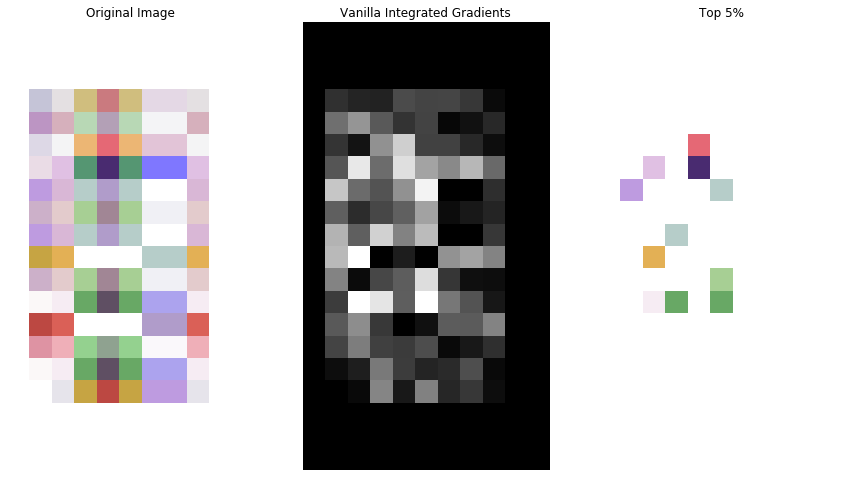

In [36]:
# Load the image
im = pickles_analysis[0]

# Compute the vanilla mask
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensor to 2D grayscale
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)


# Render the saliency masks
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 5% of the image.
# !!! The 5% of top pixels here generated keeps into account the white padding added, which should be cropped,
# this is the next step that will be implemented
mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 5%', ax=P.subplot(ROWS, COLS, 3))

### Crop padding from the images
#### This allows to select the top relevant pixels factoring out the padded white areas of the images

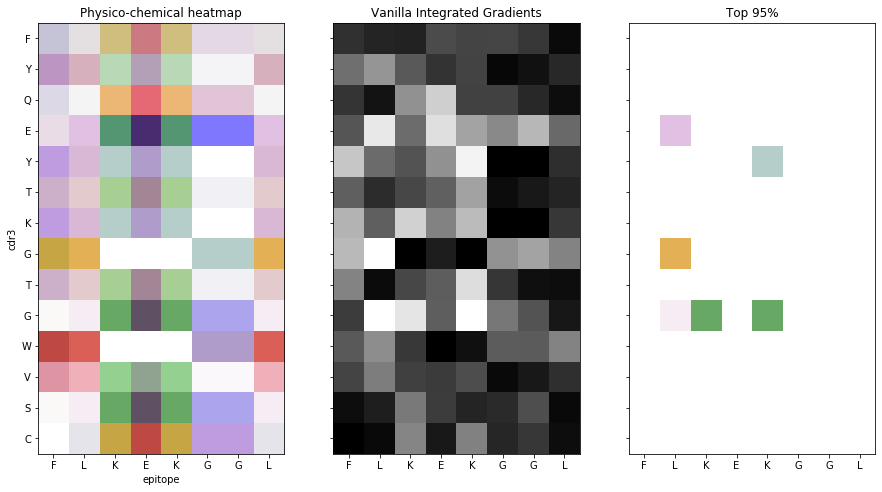

In [37]:
im_mask = np.array(im)
mask = (im_mask != 0.0).all(axis=(2)) # select all rows and columns that are not entirely white
im_mask = im_mask[(mask == True).any(axis=1),:]
im_mask = im_mask[:,(mask == True).any(axis=0)]

vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]

# select top 5% of the pixels 
r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
top_mask = np.array(im)
top_mask = top_mask[(mask == True).any(axis=1),:]
top_mask = top_mask[:,(mask == True).any(axis=0)]
top_mask[~r_mask] = 0 # set the other pixels to white

fig,(ax, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
img = ax.imshow(im_mask)
img2 = ax2.imshow(vanilla_mask_grayscale, cmap=P.cm.gray, vmin=0, vmax=1)
img3 = ax3.imshow(top_mask)


ax.set_xticks(np.arange(len(df['antigen.epitope'][0])))
ax.set_yticks(np.arange(len(df['cdr3'][0])))
ax.set_yticklabels(df['cdr3'][0][::-1])
ax.set_ylabel('cdr3')
ax.set_xlabel('epitope')
ax.set_xticklabels(df['antigen.epitope'][0])
ax.set_title("Physico-chemical heatmap")
ax2.set_title("Vanilla Integrated Gradients")
ax3.set_title("Top 95%")

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

#### Extract the top pairs highlighted previously, for each image

In [38]:
# definition of the function for the extraction
def extract_pairs(mask, mask_grayscale, im_mask, cdr3, epitope):
    output = []
    reverse_cdr3 = cdr3[::-1] # reversing of the cdr3 sequence is needed since it is plotted from the origin moving 
                              # "upwards", following the positive y-axis direction
    relevant_indices = np.transpose(np.nonzero(mask)) # grab the non zero elements of the mask
    for pair in relevant_indices:
        res1 = reverse_cdr3[pair[0]]
        res2 = epitope[pair[1]]
        pxlv = mask_grayscale[pair[0], pair[1]]
        real_pxlv = im_mask[pair[0], pair[1]]
        # saves all the relevant information of the pixel pair
        # the sequences, the residues, their correct offsets, the property values and their IG value (grayvalue)
        output.append({'cdr3': cdr3, 'epitope': epitope, 'Res1' : res1, 'Res2': res2, 
                       'Off1' : len(cdr3)-pair[0]-1, 'Off2': pair[1], 'gray_value': pxlv,
                       'property1' : real_pxlv[0],'property2' : real_pxlv[1],'property3' : real_pxlv[2],'property4' : real_pxlv[3]})

    return(output)

In [39]:
data = [] 

# loop to extract the pairs from each image
for i in range(df.shape[0]):
    im = pickles_analysis[i]
    
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
          im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)
    
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

    im_mask = np.array(im)
    mask = (im_mask != 0.0).all(axis=(2))
    im_mask = im_mask[(mask == True).any(axis=1),:]
    im_mask = im_mask[:,(mask == True).any(axis=0)]
    
    vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
    vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]


    r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
    
    data.extend(extract_pairs(r_mask, vanilla_mask_grayscale, im_mask,
                              df['cdr3'][i], df['antigen.epitope'][i]))
    if not(i%100):
        print(i)
# save the pairs found to a csv file to easily access the data if needed,
# since this past operation is very time consuming
pairings = pd.DataFrame(data)

pairings.to_csv('pairings.csv',index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800


In [40]:
# pairs extracted
pairings = pd.read_csv('pairings.csv')
pairings

,cdr3,epitope,Res1,Res2,Off1,Off2,gray_value,property1,property2,property3,property4
0,CSVWGTGKTYEQYF,FLKEKGGL,E,L,10,1,0.908726,0.522222,0.000000,0.565602,0.250000
1,CSVWGTGKTYEQYF,FLKEKGGL,Y,K,9,4,0.956598,0.388889,0.591687,0.550649,0.468750
2,CSVWGTGKTYEQYF,FLKEKGGL,G,L,6,1,1.000000,0.855556,0.591687,0.116250,0.750000
3,CSVWGTGKTYEQYF,FLKEKGGL,G,L,4,1,1.000000,0.566667,0.000112,0.387242,0.078125
4,CSVWGTGKTYEQYF,FLKEKGGL,G,K,4,2,0.896325,0.288889,0.591799,0.270992,0.828125
...,...,...,...,...,...,...,...,...,...,...,...
94499,CASSPGGGKETQYF,DEEDAIAAY,G,D,6,3,0.971419,0.344444,0.224850,0.449340,0.468750
94500,CASSPGGGKETQYF,DEEDAIAAY,G,A,5,4,0.988076,0.633333,0.583423,0.442049,0.546875
94501,CASSPGGGKETQYF,DEEDAIAAY,G,I,5,5,1.000000,0.933333,0.591687,0.116250,0.750000
94502,CASSPGGGKETQYF,DEEDAIAAY,G,A,5,6,1.000000,0.633333,0.583423,0.442049,0.546875


In [41]:
# calculate correlation between numeric data. Slight positive correlation for property 1,2 and 4
# while the 3rd is slightly negativly correlated with the relevance the pixel has
# Properties: Hydrophobicity, Isoelectric Point, Mass, Hydrophilicity
pairings.drop(columns=['cdr3','epitope','Res1','Res2','Off1','Off2']).corr()

,gray_value,property1,property2,property3,property4
gray_value,1.000000,0.132951,0.072833,-0.021998,0.125484
property1,0.132951,1.000000,0.251948,-0.567076,0.442305
property2,0.072833,0.251948,1.000000,0.185548,0.556436
property3,-0.021998,-0.567076,0.185548,1.000000,-0.176680
property4,0.125484,0.442305,0.556436,-0.176680,1.000000


Text(0.5, 0, 'Offset2')

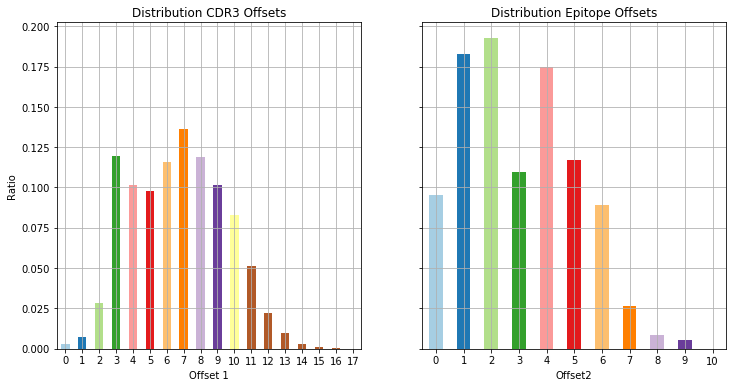

In [42]:
# plot distributions' ratios of the two sequences' offsets
# the tails see a lower ratio, with the majority of the relevant pixels distributed in the mid sections
f, axes = plt.subplots(1, 2, sharey=True)
pairings['Off1'].value_counts(normalize=True).sort_index().plot(ax=axes[0],title = 'Distribution CDR3 Offsets', color=plt.cm.Paired(np.arange(len(pairings))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))
pairings['Off2'].value_counts(normalize=True).sort_index().plot(ax=axes[1],title = 'Distribution Epitope Offsets', color=plt.cm.Paired(np.arange(len(pairings))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))
axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Offset 1")
axes[1].set_xlabel("Offset2")

#### Calculate the "relevance ratio" as the ratio of the number of times the residue appers among the relevant pixels, over the number of times the residue appears in the dataset.

Text(0.5, 0, 'Ratio of relevance')

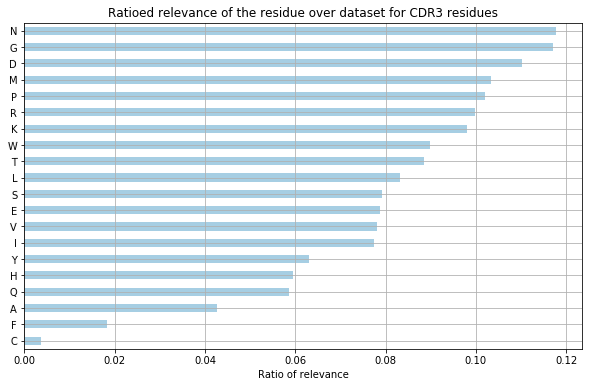

In [43]:
# First case is for the cdr3 sequences.
# As expected Cysteine (C) is the least relevant among the amino acids as it is a marker, signaling the beginning
# of the cdr3 region, without carrying additional information and being relevant to the binding.
# The other amino acids are more equally represented
df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res2','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)

for un in df['Res1'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)

mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
    
df = df.groupby(['Res1']).size().reset_index(name='counts')
df['total'] = df['Res1'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']

#print(df) # remove comment to see the actual counts

df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist()},
                         index=df['Res1'].tolist()).sort_values(by='relevance_ratio')
ax = ratioed.plot(title = 'Ratioed relevance of the residue over dataset for CDR3 residues',
                       color=plt.cm.Paired(np.arange(len(df))), kind='barh', grid = True, rot = 1, legend = False, figsize=(10,6))

ax.set_xlabel("Ratio of relevance")

Text(0.5, 0, 'Ratio of relevance')

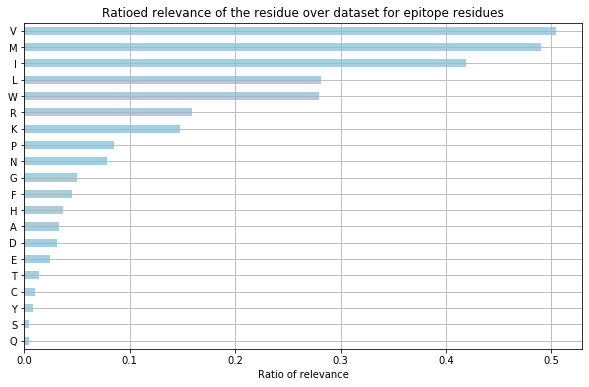

In [44]:
# second case is for the epitopes
# Valine (V), Methionine (M) and Isoleucine (I) have a relevance ratio far greater than the rest of the AAs,
# even close to 0.5, suggesting that they are frequently among the selected pairs when present in the epitope sequence.
df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res1','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)

for un in df['Res2'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)

mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
    
df = df.groupby(['Res2']).size().reset_index(name='counts')
df['total'] = df['Res2'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']

#print(df) # remove comment to see the actual counts

df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist()},
                         index=df['Res2'].tolist()).sort_values(by='relevance_ratio')
ax = ratioed.plot(title = 'Ratioed relevance of the residue over dataset for epitope residues',
                       color=plt.cm.Paired(np.arange(len(df))), kind='barh', grid = True, rot = 1, legend = False, figsize=(10,6))

ax.set_xlabel("Ratio of relevance")

#### Calculate the representation in percentage of the residues. Relevant amino acids previously identified may prove to be also very frequent, allowing to find valuable rules in the data.

Text(0.5, 0, 'Residues')

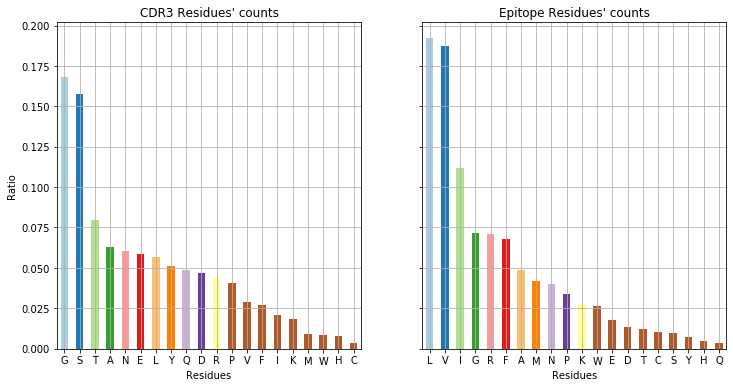

In [45]:
# Regarding the epitopes Valine (V) and Isoleucine (I) are also the most frequent residues among the relevant ones and
# even Leucine (L) was among the above-average relevant residues, making them very interesting.
# For the cdr3 sequence Glycine (G) emerges as the most frequent AA and can be seen also among the most frequently relevant.
df1 = pd.read_csv('pairings.csv')
f, axes = plt.subplots(1, 2, sharey=True)
df1['Res1'].value_counts(normalize=True).plot(ax=axes[0],title = 'CDR3 Residues\' counts', color=plt.cm.Paired(np.arange(len(df1))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))

df1['Res2'].value_counts(normalize = True).plot(ax=axes[1],title = 'Epitope Residues\' counts', color=plt.cm.Paired(np.arange(len(df1))), grid = True,
                                                     kind='bar', rot = 1, legend = False, figsize=(12,6))

axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Residues")
axes[1].set_xlabel("Residues")

#### Previous aspects combined into a single plot

Text(0.5, 0, 'Residues')

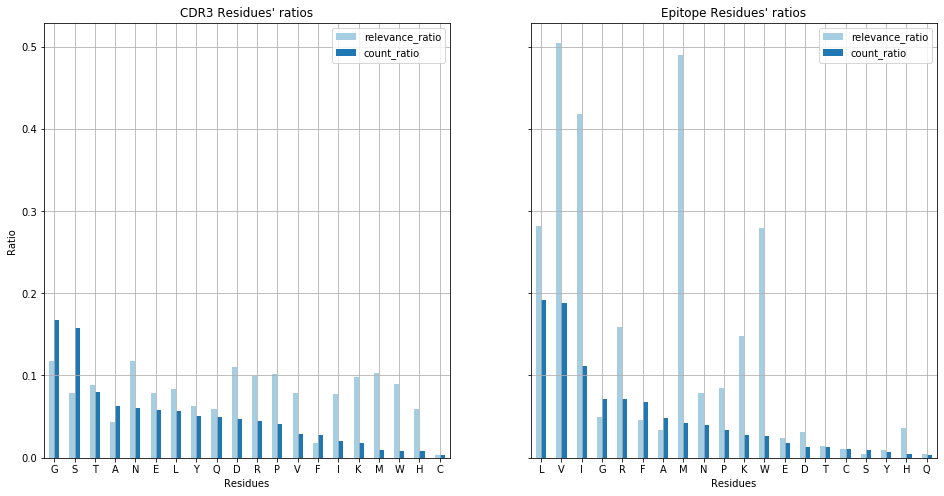

In [46]:
df = pd.read_csv('pairings.csv')
n_rows = len(df)
df.drop(columns=['epitope','Off2','Res2','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res1'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res1']).size().reset_index(name='counts')
df['total'] = df['Res1'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
df['count_ratio'] = df['counts']/n_rows
#print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist(),
                       'count_ratio': df['count_ratio'].tolist()},
                         index=df['Res1'].tolist())
ratioed['count_ratio'] = df1['Res1'].value_counts(normalize=True)



df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res1','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res2'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res2']).size().reset_index(name='counts')
df['total'] = df['Res2'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
df['count_ratio'] = df['counts']/n_rows
#print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed2 = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist(),
                        'count_ratio': df['count_ratio'].tolist()},
                         index=df['Res2'].tolist())



f, axes = plt.subplots(1, 2, sharey=True)
ratioed.sort_values(by=['count_ratio'], ascending=False).plot(ax=axes[0],title = 'CDR3 Residues\' ratios', color=plt.cm.Paired(np.arange(len(df1))),
                                                   grid = True, kind='bar', rot = 1, figsize=(16,8))

ratioed2.sort_values(by=['count_ratio'], ascending=False).plot(ax=axes[1],title = 'Epitope Residues\' ratios', color=plt.cm.Paired(np.arange(len(df1))), grid = True,
                                                     kind='bar', rot = 1,figsize=(16,8))

axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Residues")
axes[1].set_xlabel("Residues")

#### Analyzing the occurrences in conjunction of residues

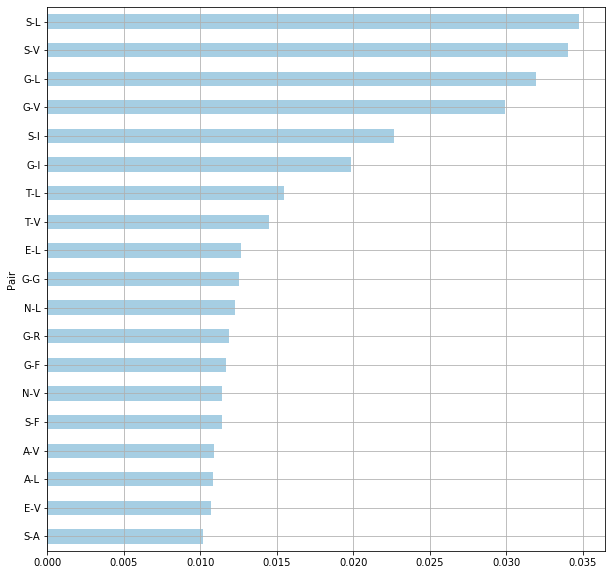

In [47]:
# What can be gathered by analyzing how residues appear in the pairs is not more than what was previously found. 
# The most frequent pairs are made of the most frequent residues with no very frequent outliers present.
pairdf = pd.read_csv('pairings.csv')
n_pairs = len(pairdf)
pairdf.drop(columns=['cdr3','epitope','Off2','Off1','property1','property2','property3','property4'],inplace = True)
pairdf = pairdf.groupby(["Res1",'Res2']).size().reset_index()
pairdf = pairdf.set_axis(['Res1','Res2','CountRatio'], axis = 1)
pairdf['CountRatio'] = pairdf['CountRatio']/n_pairs
pairdf['Pair'] = pairdf['Res1'] + '-' + pairdf['Res2']
pairdf.drop(columns=['Res1','Res2'], inplace = True)
pairdf = pairdf.set_index('Pair')
pairdf.drop(pairdf[pairdf['CountRatio'] < 0.01].index, inplace=True) # remove very infrequent pairs
pairdf.sort_values(by = 'CountRatio').plot(kind = 'barh', figsize=(10,10),color=plt.cm.Paired(np.arange(len(pairdf))), grid = True, legend = False)

# 3D Analysis
#### Integration of 3D data from curated databases to determine if the relevant pairs found with the explainability techniques overlap with real points of interaction between cdr3 regions and epitopes.

In [48]:
# function that maps into the correct offset number the values present in the pdb files that will be downloaded
def fasta2pdb_mapper(pdb_filepath, pdb_id, model, chain, fasta_seq):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_filepath)
    pdb_tcrb_chain = structure[model][chain]
    pdb_tcrb_sel = Selection.unfold_entities(pdb_tcrb_chain, "R")
    pdb_tcrb_seq = ''
    pdb_tcrb_id_seq = []
    for r in pdb_tcrb_sel:
        if r.get_id()[0] == ' ':
            pdb_tcrb_seq += protein_letters_3to1[r.get_resname().title()]
            pdb_tcrb_id_seq.append(r.get_id()[1])
    aligner = Align.PairwiseAligner()
    alignment = aligner.align(pdb_tcrb_seq, fasta_seq)[0]
    pdb_aligned, fasta_aligned = alignment.aligned
    pdb2fasta_mapper = {}
    for pdb_chunck, fasta_chunk in zip(pdb_aligned, fasta_aligned):
        for pdb_chunck_id, fasta_chunk_id in zip(range(pdb_chunck[0], pdb_chunck[1]),
                                                 range(fasta_chunk[0], fasta_chunk[1])):
            pdb_numbering_id = pdb_tcrb_id_seq[pdb_chunck_id]
            pdb2fasta_mapper[pdb_numbering_id] = fasta_chunk_id
    return pdb2fasta_mapper

In [49]:
# cmd to generate the predictions based on the complex_data.csv sequences
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/complex_data.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-3D.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/

2021-08-21 16:17:51,960 - root - INFO - CLI argument batch_size: 128
2021-08-21 16:17:51,960 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-21 16:17:51,960 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-21 16:17:51,961 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-21 16:17:51,961 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/'
2021-08-21 16:17:51,961 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/complex_data.csv'
2021-08-21 16:17:51,961 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-21 16:17:51,961 - root - INFO - CLI argument max_length_epitope: 11
2021-08-21 16:17:51,961 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-21 16:17:51,961 - root - INFO - CLI argument min_length_epitope: 8
2021-08-21 16:17:51,961 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-0

In [50]:
comps = pd.read_csv('complex_data.csv', sep=';')

In [51]:
# pdb files scraping function
def scrape_pdb(file_name):
    pdb_dir = './pdb_files/' # directory where the pdb files will be saved
    base_url = 'https://www.rcsb.org/structure/'
    
    # checks if the pdb has already been downloaded
    if not os.path.exists(pdb_dir + file_name.lower() +'.pdb'):
        url = base_url + file_name.lower()
        response = requests.get(url,timeout=None)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")

        try:
            a = soup.find('a', href=lambda x: x and x.endswith('download/' + file_name +'.pdb'))

            urllib.request.urlretrieve('https:' + a['href'], pdb_dir + file_name.lower() +'.pdb')
            print('Downloaded: ' + file_name.lower() +'.pdb')
        except Exception as e:
            print('Failed Download:' + e)
    else:
        print('File ' + file_name.lower() +'.pdb' + ' already exists')
comps['PDB_ID'].apply(scrape_pdb) # apply the scraping for the complexes present


File 1ao7.pdb already exists
File 1bd2.pdb already exists
File 1mi5.pdb already exists
File 1oga.pdb already exists
File 1qrn.pdb already exists
File 1qse.pdb already exists
File 1qsf.pdb already exists
File 2bnq.pdb already exists
File 2bnr.pdb already exists
File 2esv.pdb already exists
File 2f53.pdb already exists
File 2f54.pdb already exists
File 2gj6.pdb already exists
File 2nx5.pdb already exists
File 2p5e.pdb already exists
File 2p5w.pdb already exists
File 2pye.pdb already exists
File 2vlj.pdb already exists
File 2vlk.pdb already exists
File 2vlr.pdb already exists
File 2ypl.pdb already exists
File 3dxa.pdb already exists
File 3ffc.pdb already exists
File 3gsn.pdb already exists
File 3h9s.pdb already exists
File 3hg1.pdb already exists
File 3kpr.pdb already exists
File 3kps.pdb already exists
File 3mv7.pdb already exists
File 3mv8.pdb already exists
File 3mv9.pdb already exists
File 3o4l.pdb already exists
File 3pwp.pdb already exists
File 3qdg.pdb already exists
File 3qdj.pdb 

0     None
1     None
2     None
3     None
4     None
      ... 
83    None
84    None
85    None
86    None
87    None
Name: PDB_ID, Length: 88, dtype: object

In [52]:
# function to scrape the contact txt files
def scrape_contact(file_name, epitope_chain, tcrb_chain):
    
    # directory where zip files will be downloaded
    download_dir = '/Users/fabio_air/Downloads/'
    # directory where the contact files will be placed
    contacts_dir = './contacts/'
    # directory where the chrome drive is stored
    # can be downloaded here: https://chromedriver.chromium.org/
    chromedriver_dir = '/Users/fabio_air/Downloads/chromedriver'
    # url of the site to explore
    base_url = 'https://www.mrc-lmb.cam.ac.uk/pca/redirect/'
    
    # checks if contact file exists already
    if not os.path.exists(contacts_dir + file_name + '_' + epitope_chain + '-' + tcrb_chain + '.txt'):
        
        url = base_url + file_name
    
        # webdriver setup
        options = webdriver.ChromeOptions()
        options.add_argument("--disable-notifications")

        # uncomment this line to hide the browser during the scraping, may cause issues
        #options.add_argument("--headless")
        driver = webdriver.Chrome(chromedriver_dir, chrome_options=options)

        driver.get(url)
        
        # checks if the zip file remained in the directory
        if not os.path.exists(download_dir + file_name + '_txt.zip'):
            try:
                # NOTE: the time sleeps are not the optimal solution but they are useful to allow the button
                # to become active for it to be pressed. It should be pressed when the JS behind it becomes active
                time.sleep(2) 
                WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#myModal > div > div > div.modal-header > button"))).click()
                time.sleep(2) 
                WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, "savecsv"))).click()

                while not os.path.exists(download_dir + file_name + '_txt.zip'):
                    print('Waiting')
                    time.sleep(2)

                print('File ' + file_name + '_txt.zip' + ' downloaded')
                driver.quit()

            except Exception as e:
                driver.quit()
                print(e)

        else:
            print('File ' + file_name + '_txt.zip' + ' already exists')
            driver.quit()


        # extract wanted contact file
        with ZipFile(download_dir + file_name + '_txt.zip', 'r') as zip_file:
            zip_file.extract(file_name + '_' + epitope_chain + '-' + tcrb_chain + '.txt', path = contacts_dir)
            # remove original zip file
            os.remove(download_dir + file_name + '_txt.zip')
    else:
        print('File ' + file_name + '_' + epitope_chain + '-' + tcrb_chain + '.txt' + ' already exists')
        

[scrape_contact(x, y, z) for x, y, z in zip(comps['PDB_ID'], comps['epitope_chain'], comps['tcrb_chain'])]

File 1AO7_C-E.txt already exists
File 1BD2_C-E.txt already exists
File 1MI5_C-E.txt already exists
File 1OGA_C-E.txt already exists
File 1QRN_C-E.txt already exists
File 1QSE_C-E.txt already exists
File 1QSF_C-E.txt already exists
File 2BNQ_C-E.txt already exists
File 2BNR_C-E.txt already exists
File 2ESV_P-E.txt already exists
File 2F53_C-E.txt already exists
File 2F54_C-E.txt already exists
File 2GJ6_C-E.txt already exists
File 2NX5_C-E.txt already exists
File 2P5E_C-E.txt already exists
File 2P5W_C-E.txt already exists
File 2PYE_C-E.txt already exists
File 2VLJ_C-E.txt already exists
File 2VLK_C-E.txt already exists
File 2VLR_C-E.txt already exists
File 2YPL_C-E.txt already exists
File 3DXA_C-E.txt already exists
File 3FFC_C-E.txt already exists
File 3GSN_P-B.txt already exists
File 3H9S_C-E.txt already exists
File 3HG1_C-E.txt already exists
File 3KPR_C-E.txt already exists
File 3KPS_C-E.txt already exists
File 3MV7_C-E.txt already exists
File 3MV8_C-E.txt already exists
File 3MV9_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [53]:
mappings = [] # generate mappings for each pdb file downloaded
for i, comp in comps.iterrows():
    mapping = fasta2pdb_mapper('./pdb_files/' + comp['PDB_ID'].lower() + '.pdb', comp['PDB_ID'], 
                     0, comp['tcrb_chain'], comp['tcrb_seq'])
    mappings.append(mapping)

In [54]:
out = pd.read_csv('output-3D.csv')# open output of TCRex execution

In [55]:
# load images saved with pickle from predict.py
images_path = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/'
analysis_3D = [] # list of pickled Tensors
for i, o in out.iterrows():
    try:
        with open(images_path + str(o['im_name'])+'.pkl','rb') as fil:
            x = pkl.load(fil)
            analysis_3D.append(x)
    except Exception as e:
        print(e)
        
analysis_3D = tf.convert_to_tensor(analysis_3D) # conversion to tensor of the list
analysis_3D = tf.cast(analysis_3D, tf.float32) # cast to float
analysis_3D.shape

TensorShape([88, 20, 11, 4])

1AO7_C-E.txt


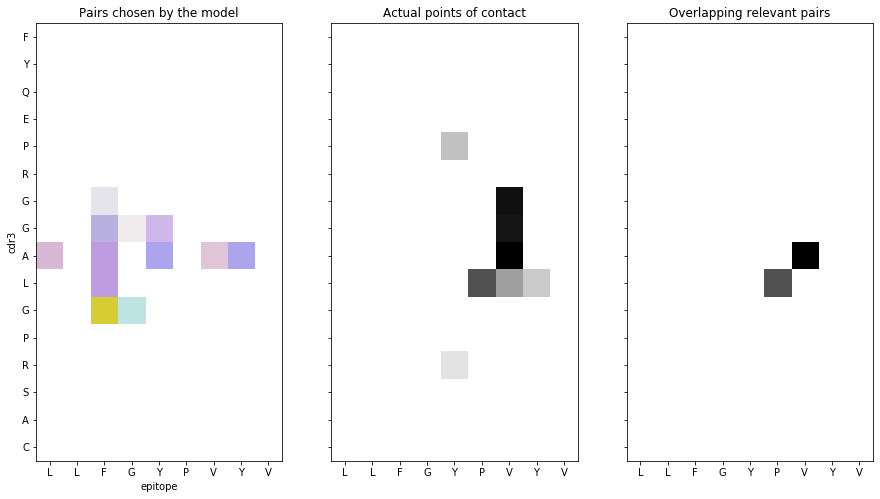

1BD2_C-E.txt


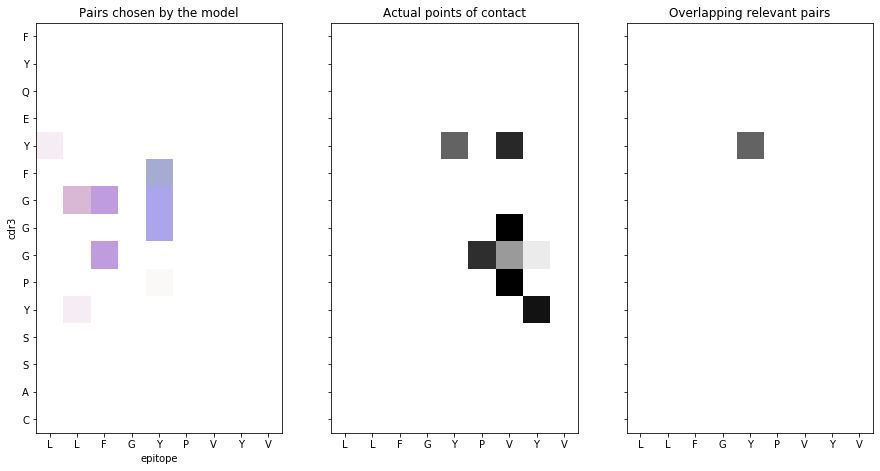

1MI5_C-E.txt


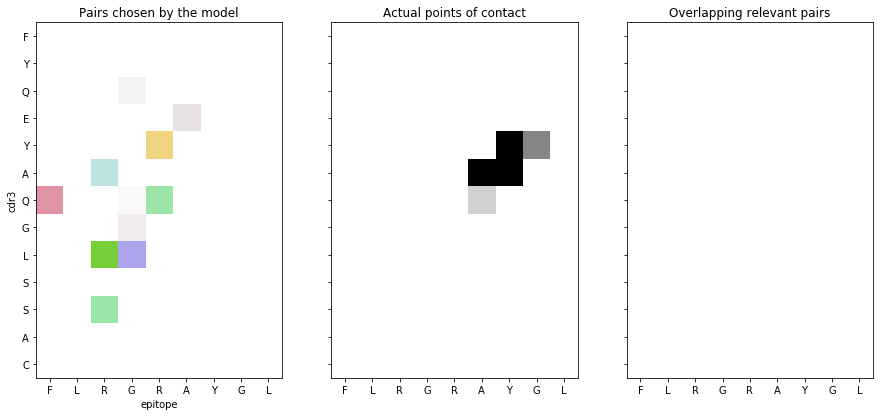

1OGA_C-E.txt


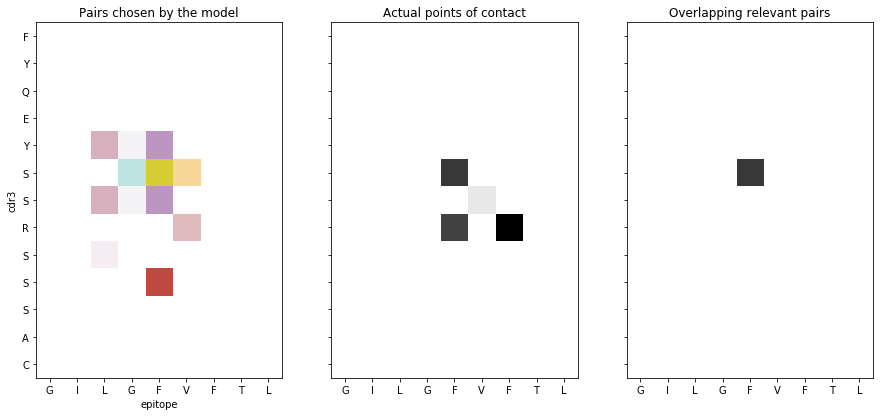

1QRN_C-E.txt


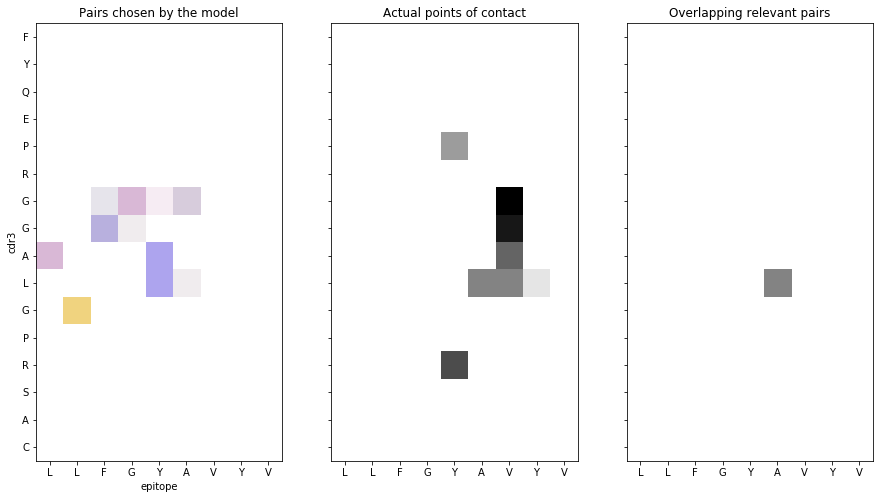

1QSE_C-E.txt


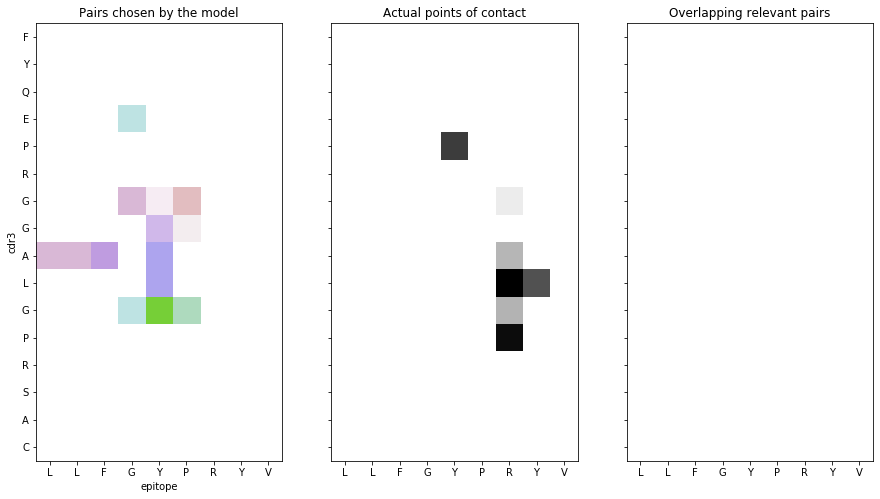

1QSF_C-E.txt


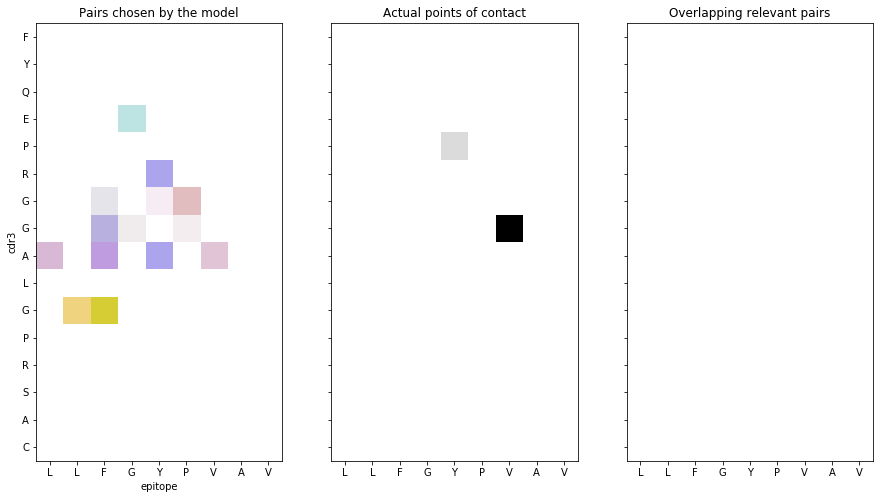

2BNQ_C-E.txt


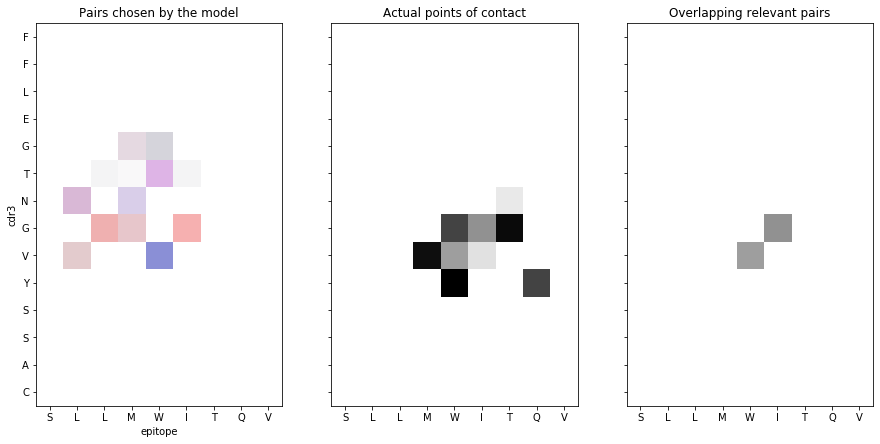

2BNR_C-E.txt


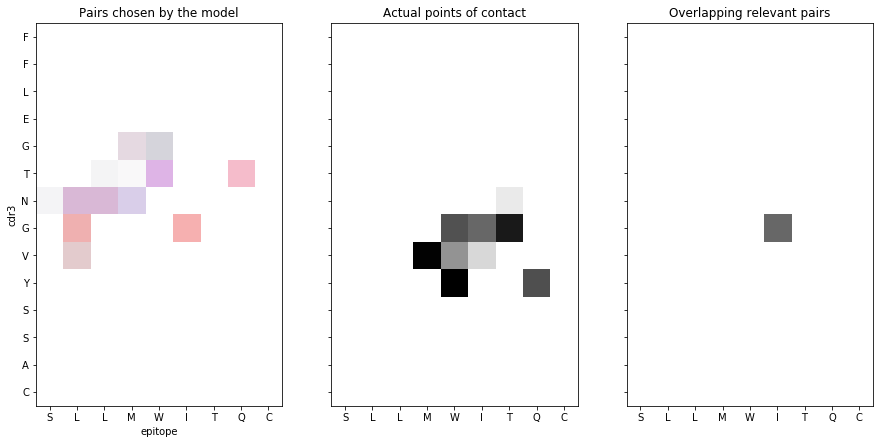

2ESV_P-E.txt


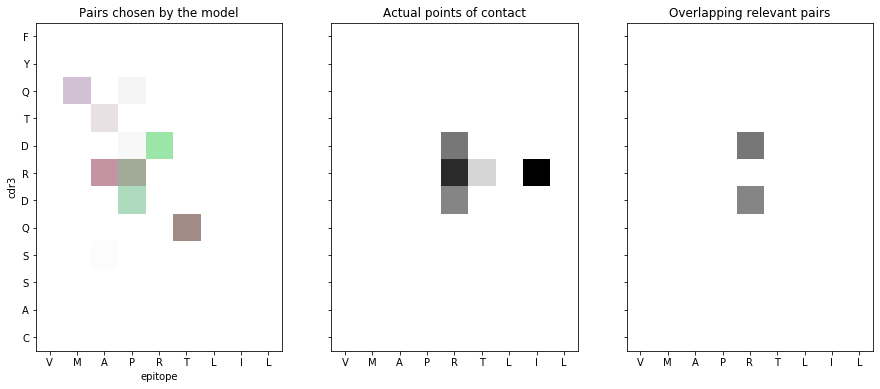

2F53_C-E.txt


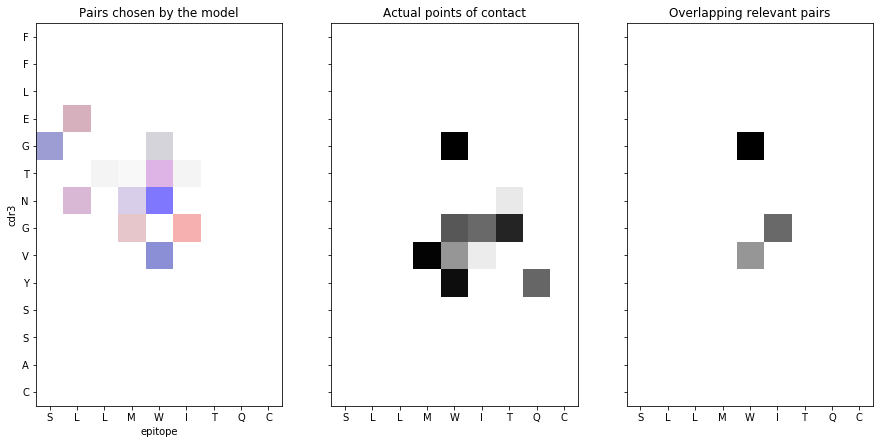

2F54_C-E.txt


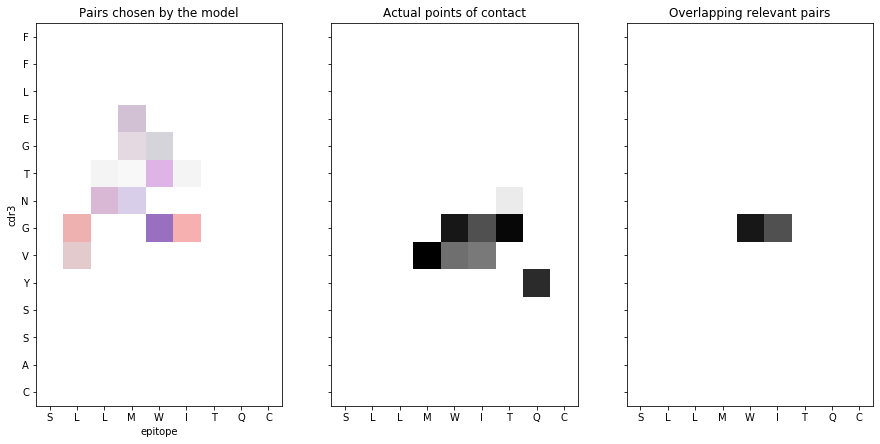

2GJ6_C-E.txt


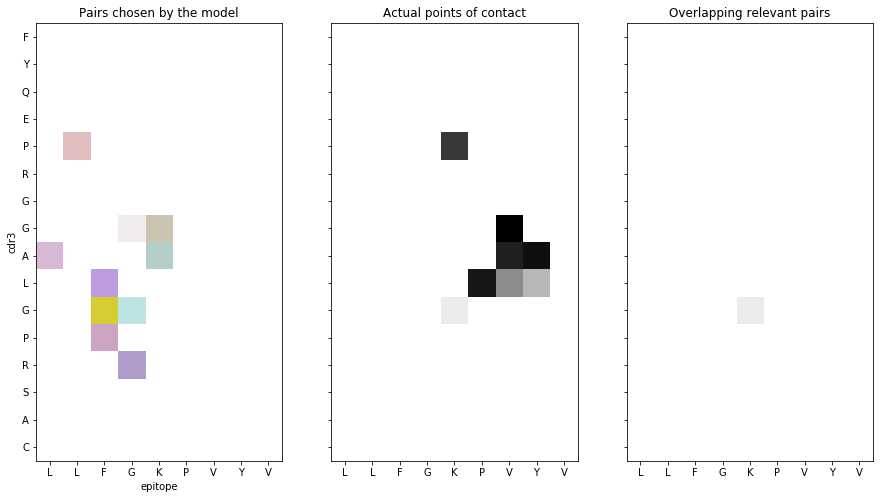

2NX5_C-E.txt


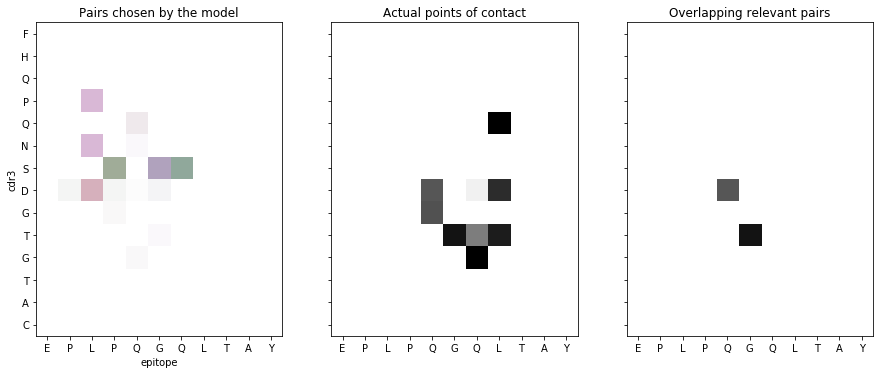

2P5E_C-E.txt


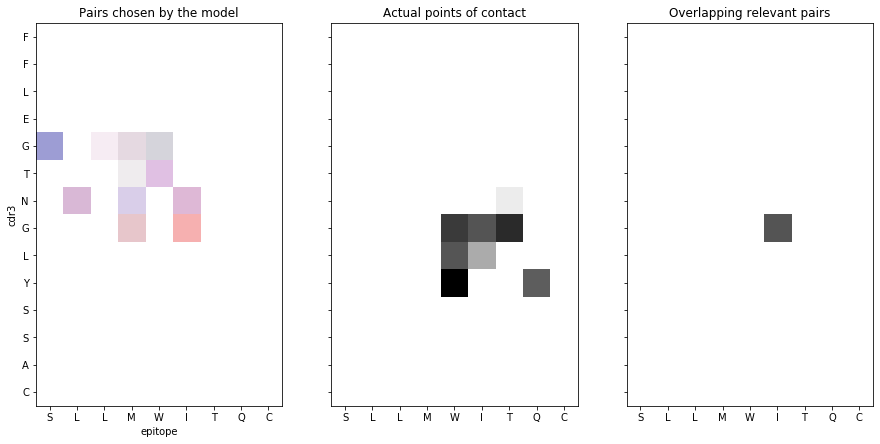

2P5W_C-E.txt


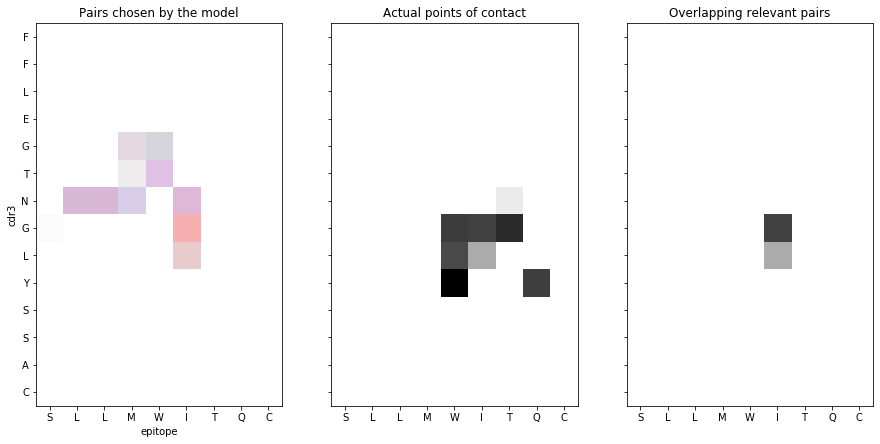

2PYE_C-E.txt


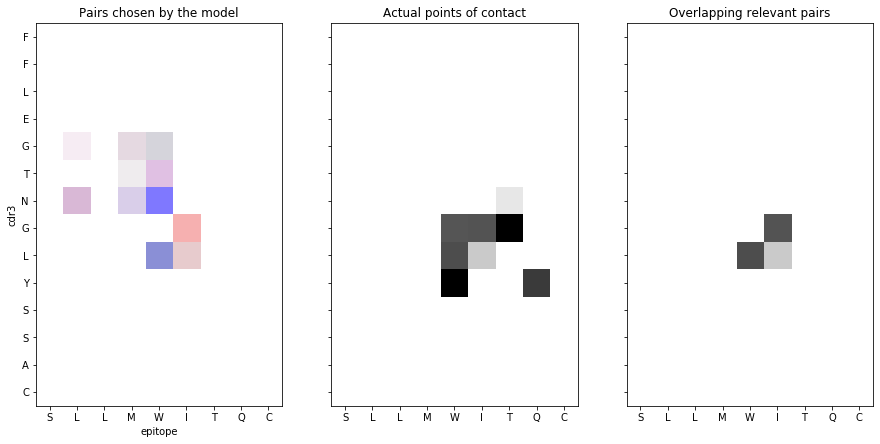

2VLJ_C-E.txt


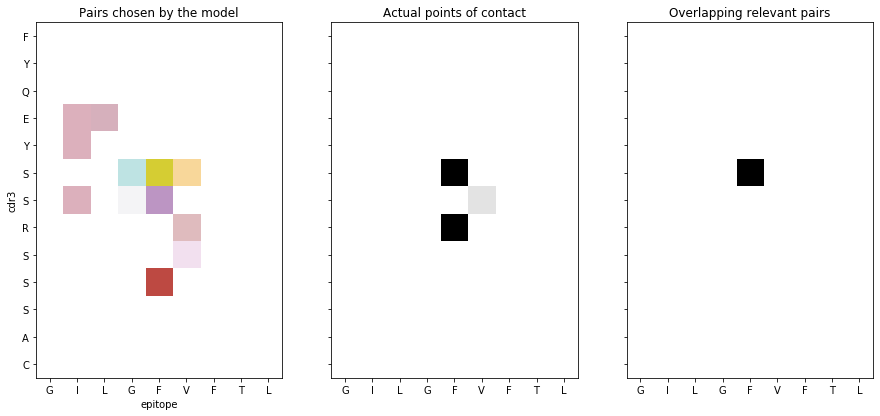

2VLK_C-E.txt


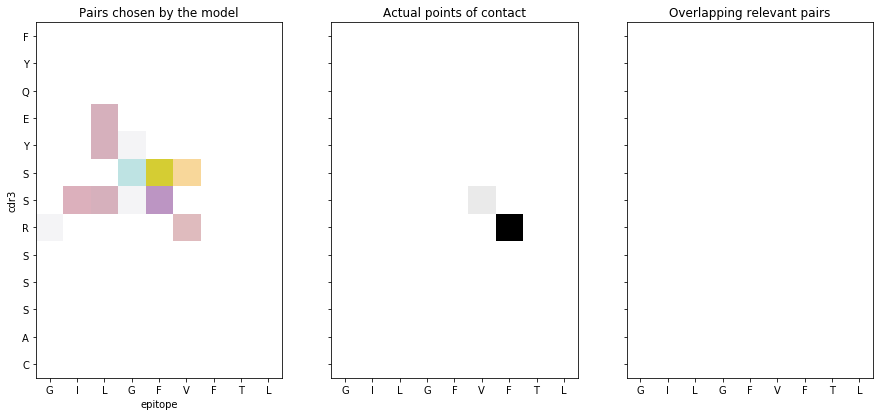

2VLR_C-E.txt


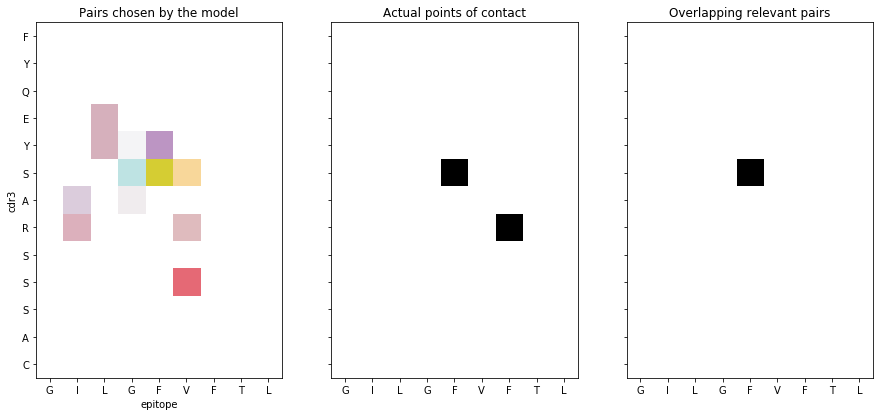

2YPL_C-E.txt


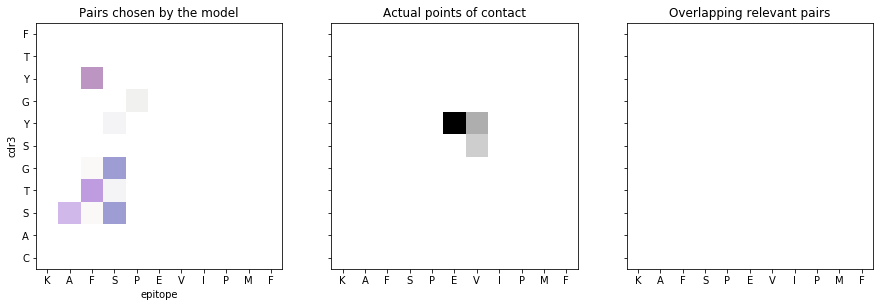

3DXA_C-E.txt


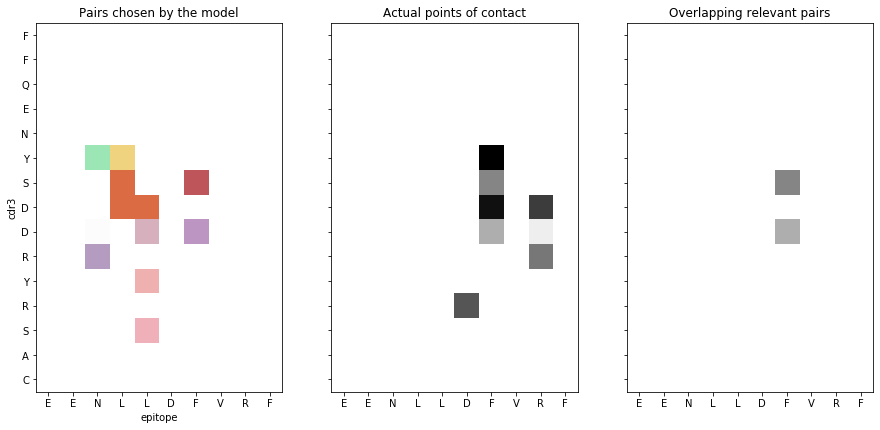

3FFC_C-E.txt


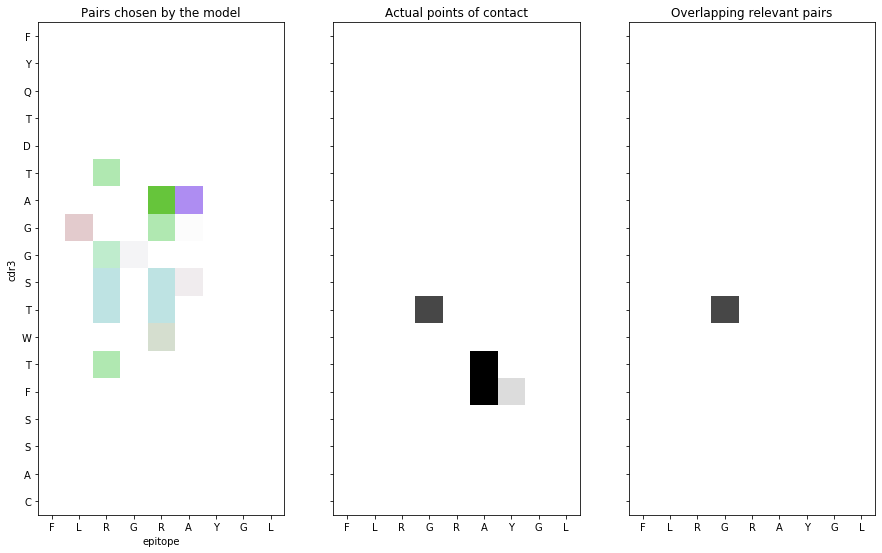

3GSN_P-B.txt


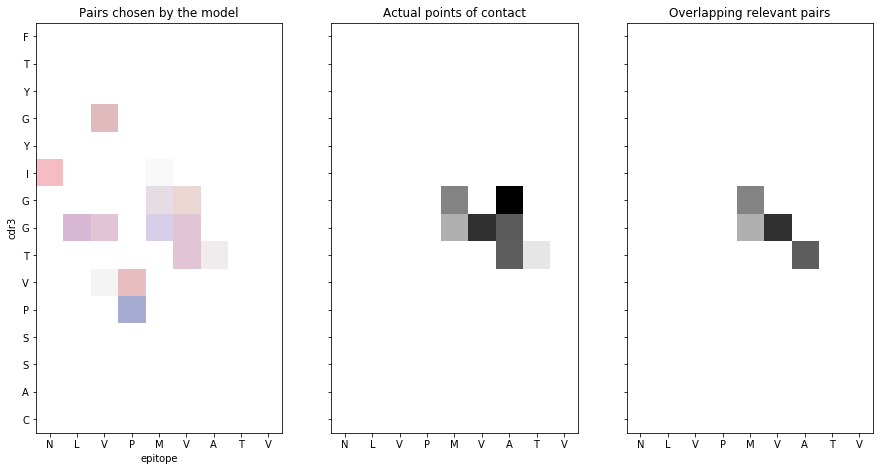

3H9S_C-E.txt


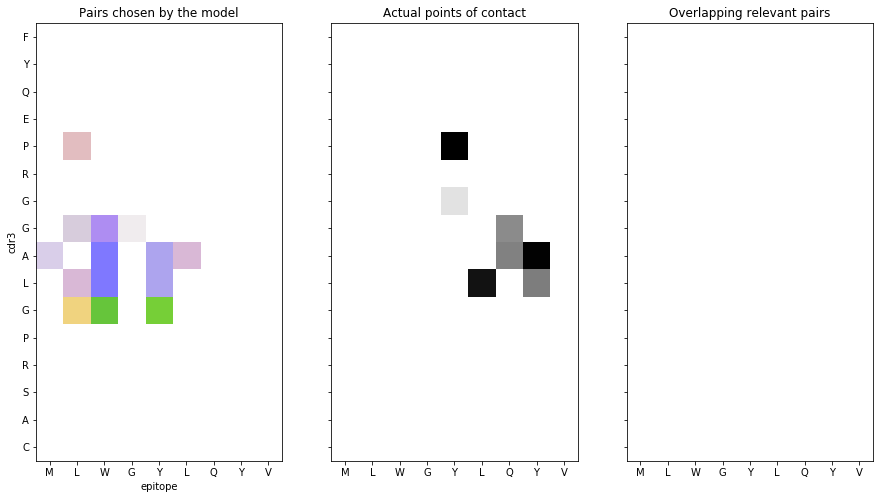

3HG1_C-E.txt


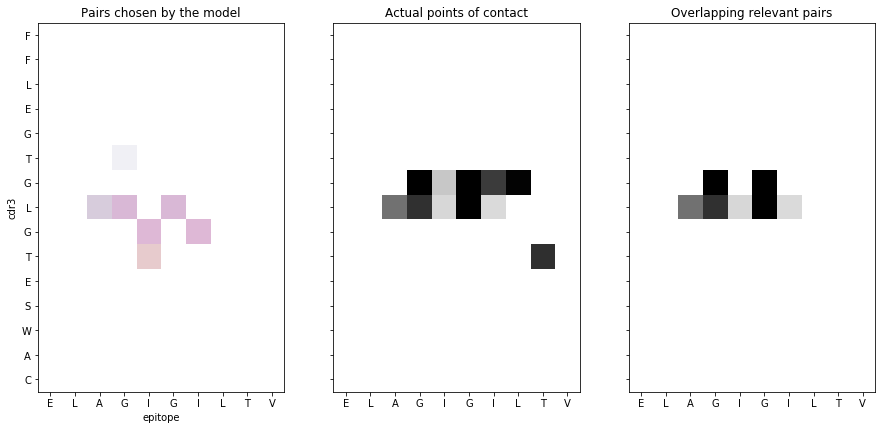

3KPR_C-E.txt


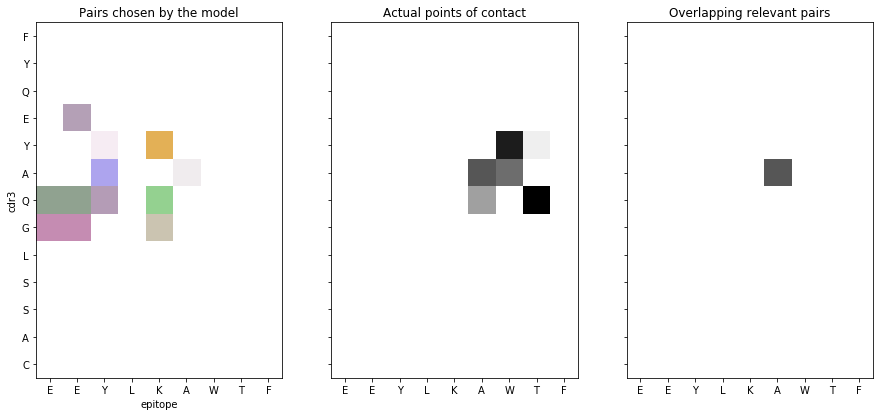

3KPS_C-E.txt


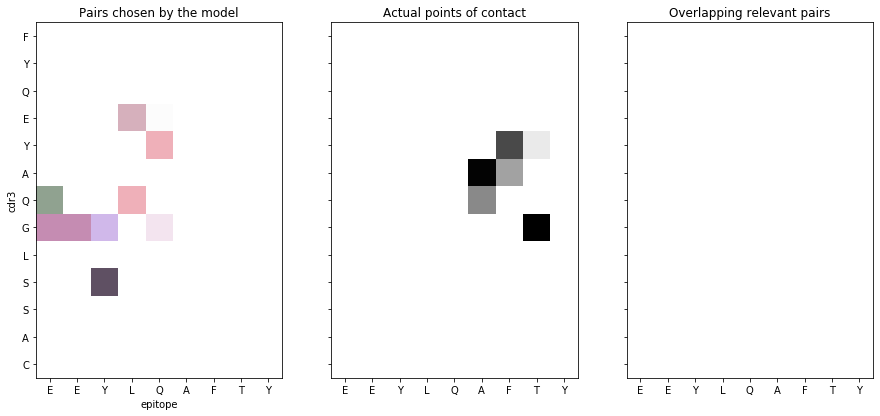

3MV7_C-E.txt


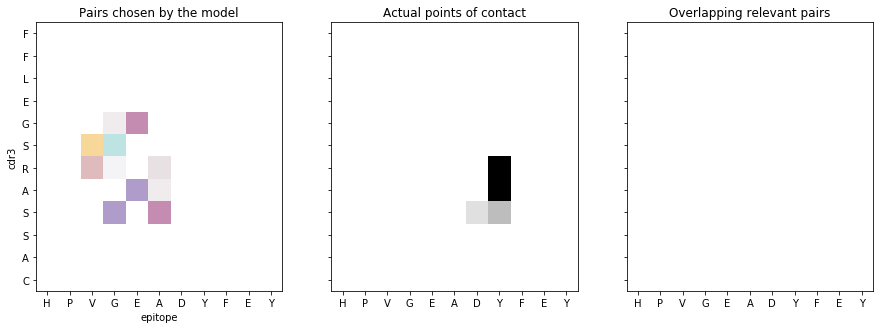

3MV8_C-E.txt


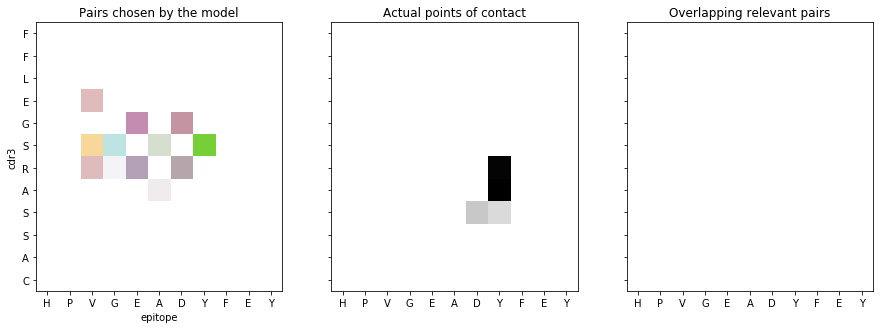

3MV9_C-E.txt


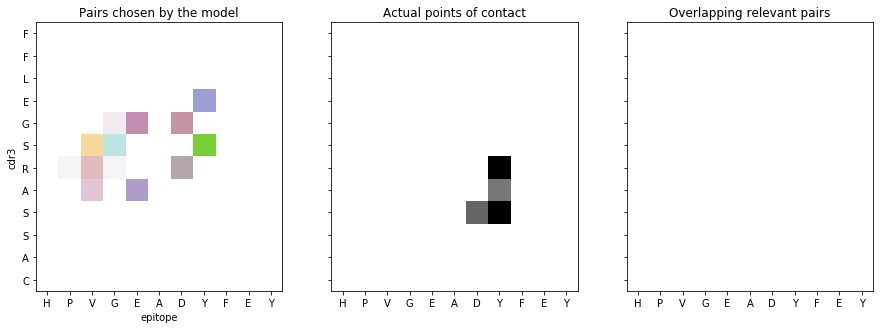

3O4L_C-E.txt


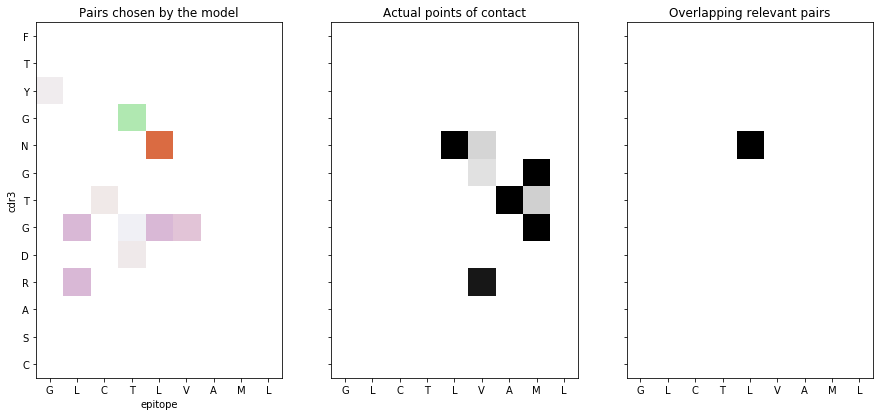

3PWP_C-E.txt


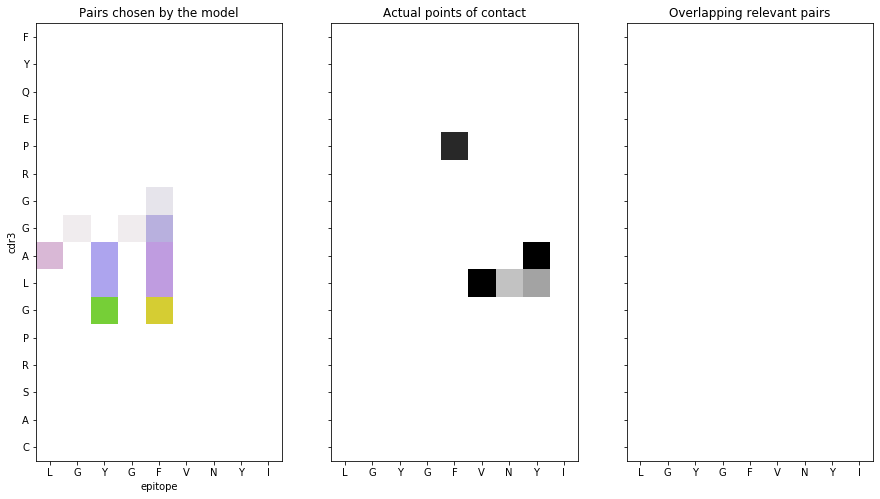

3QDG_C-E.txt


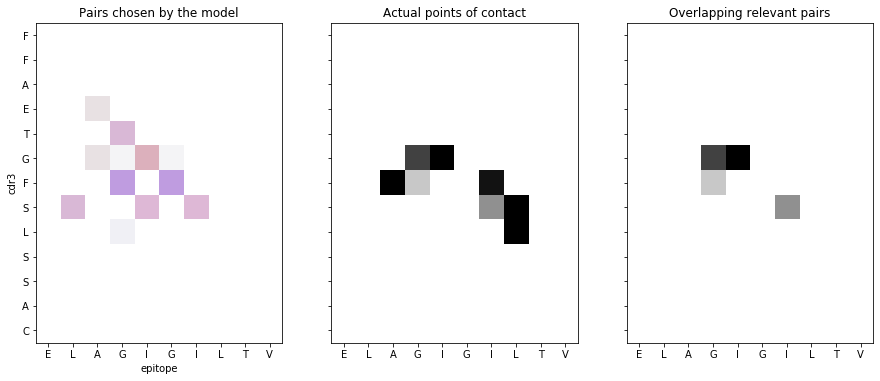

3QDJ_C-E.txt


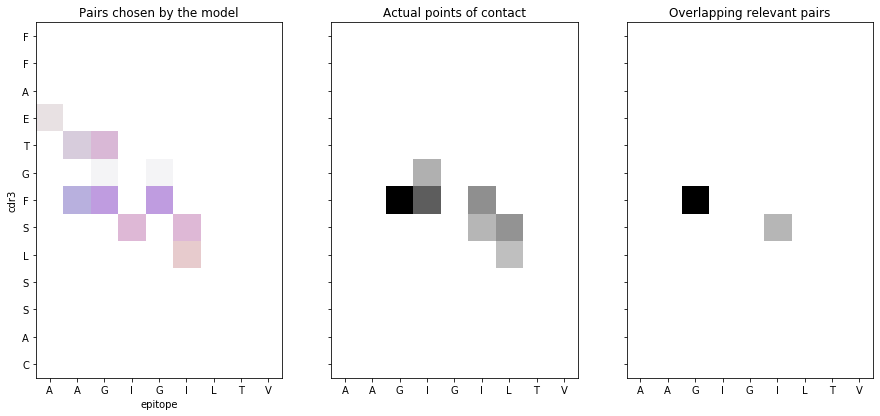

3QDM_C-E.txt


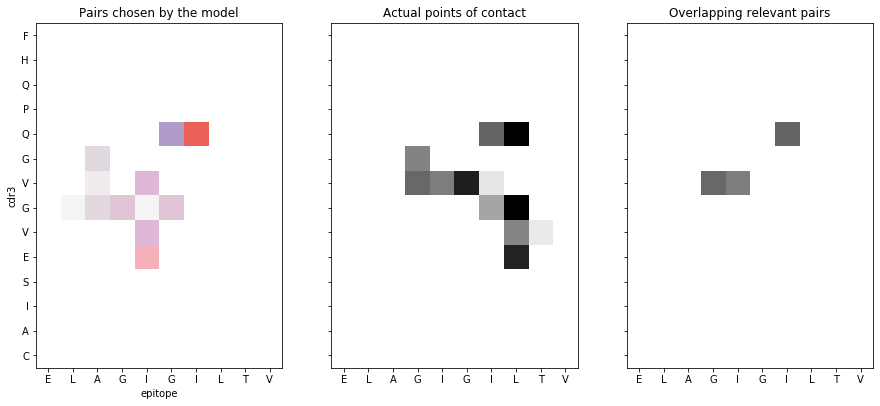

3QEQ_C-E.txt


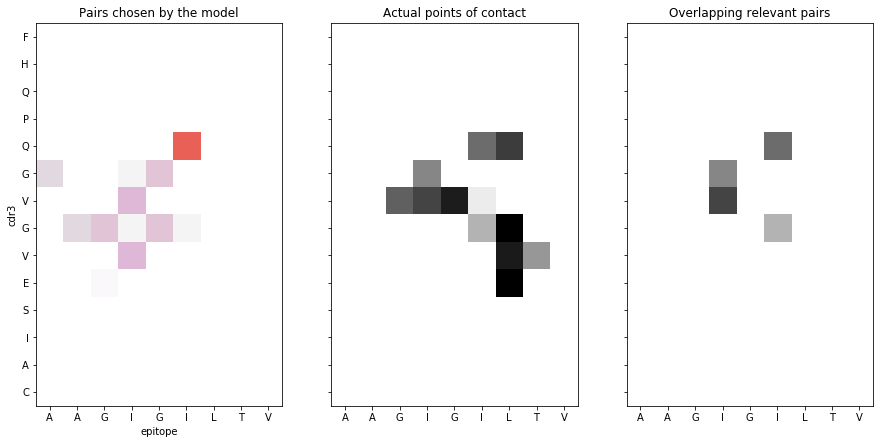

3QFJ_C-E.txt


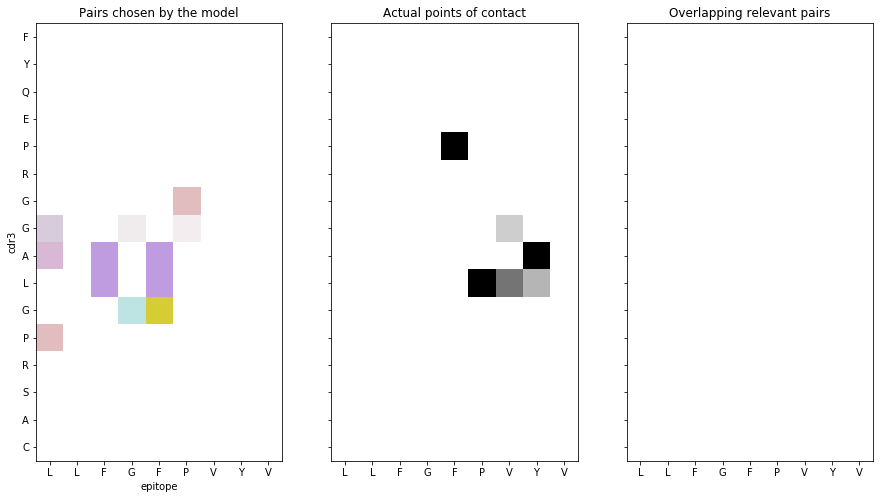

3SJV_C-E.txt


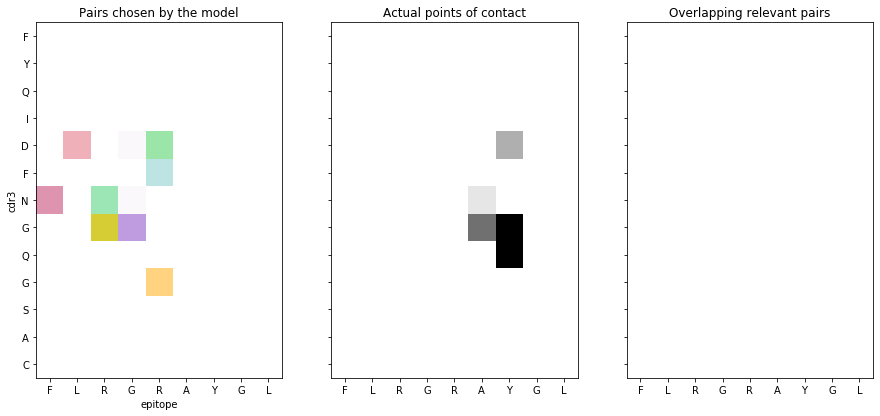

3UTS_C-E.txt


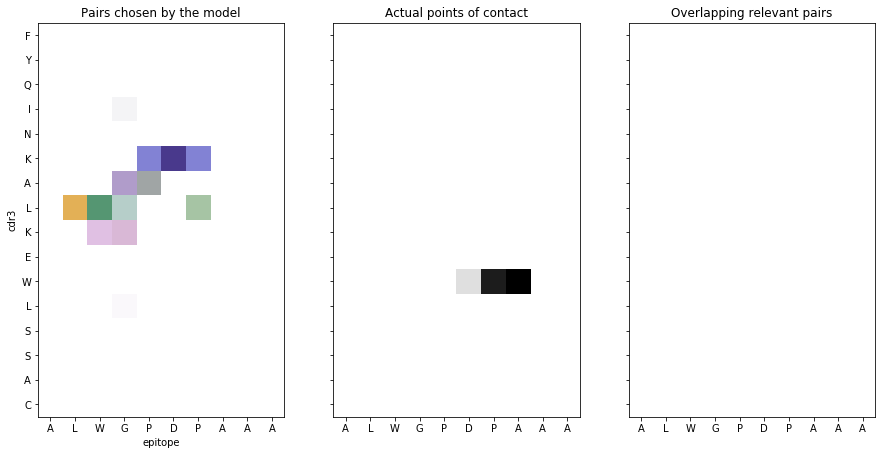

3UTT_C-E.txt


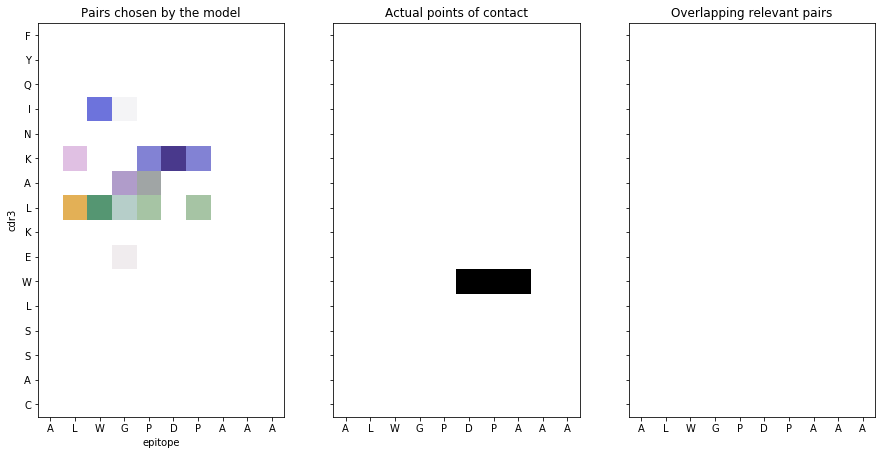

3VXM_C-E.txt


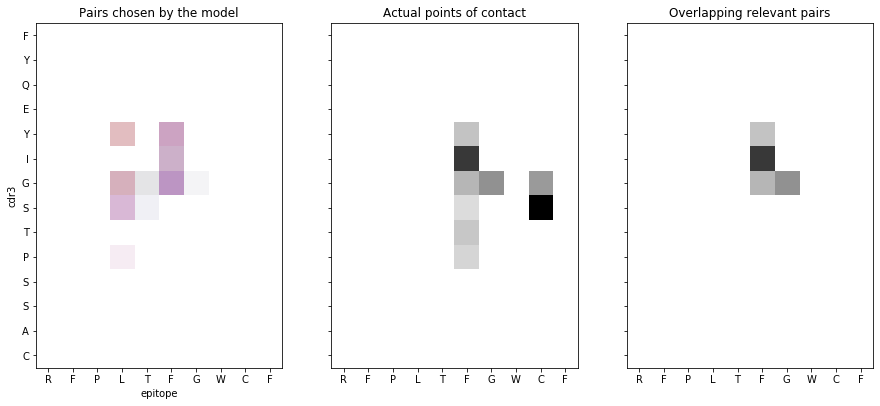

4EUP_F-H.txt


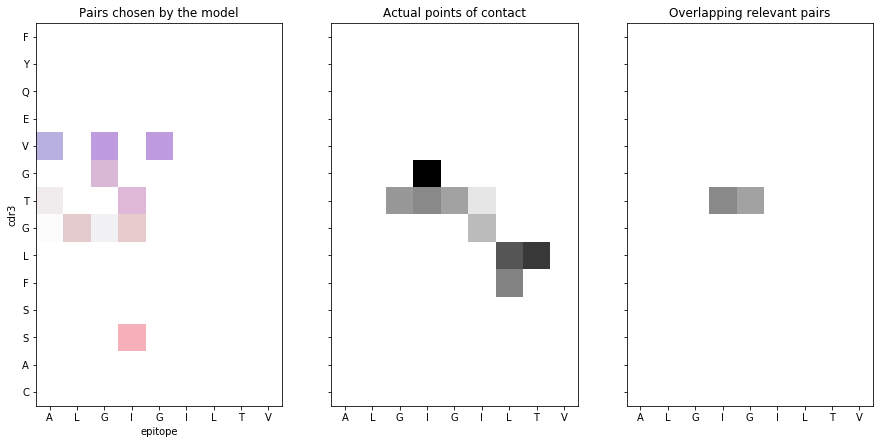

4FTV_C-E.txt


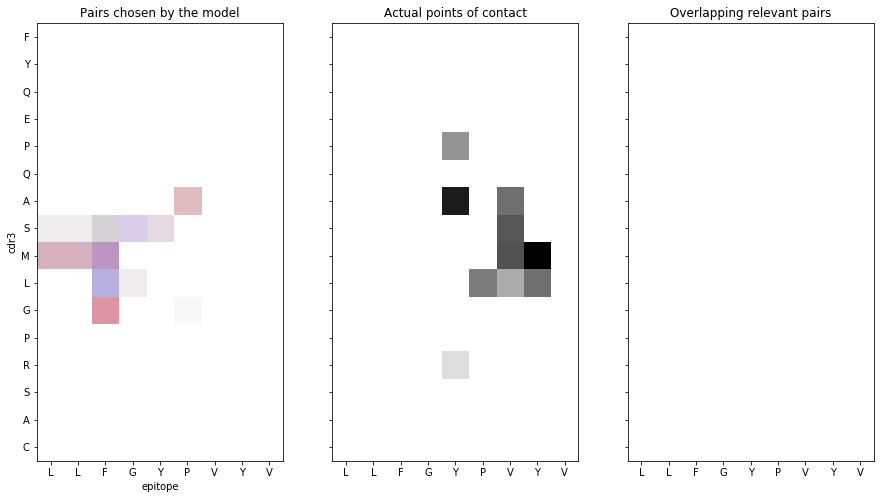

4G8G_C-E.txt


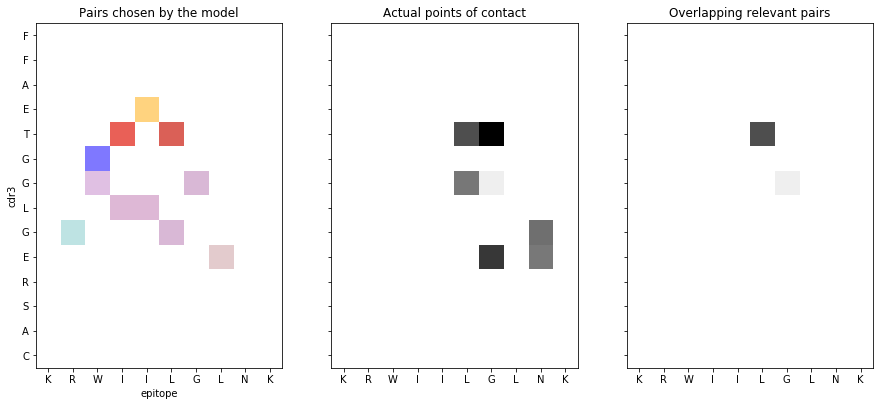

4G9F_C-E.txt


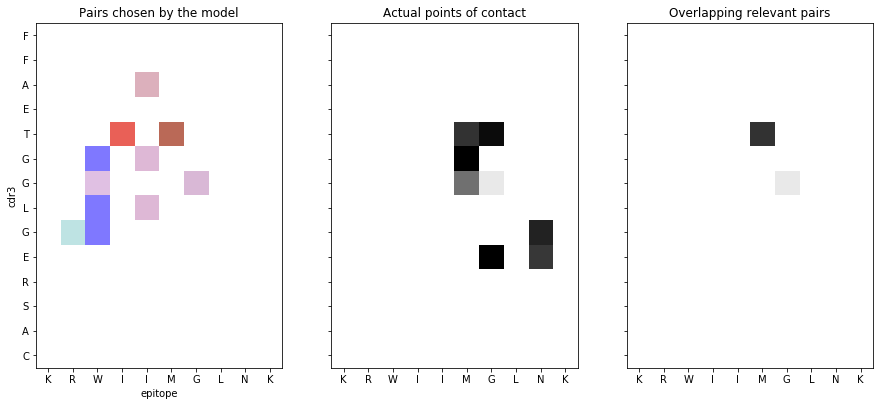

4JFD_C-E.txt


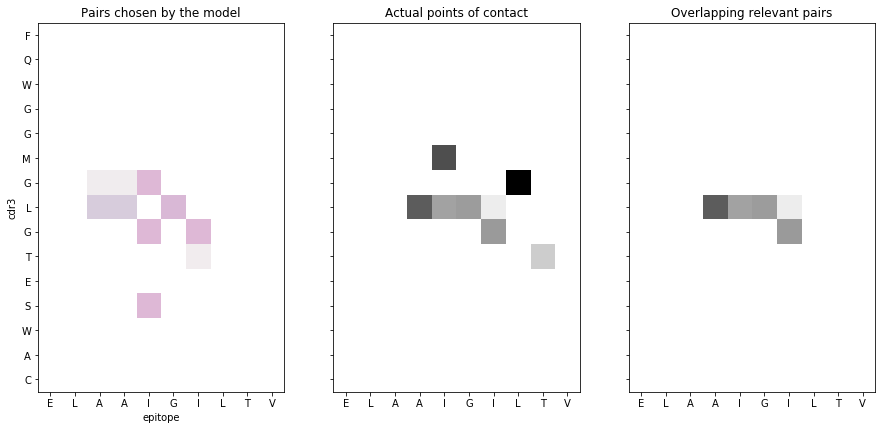

4JFE_C-E.txt


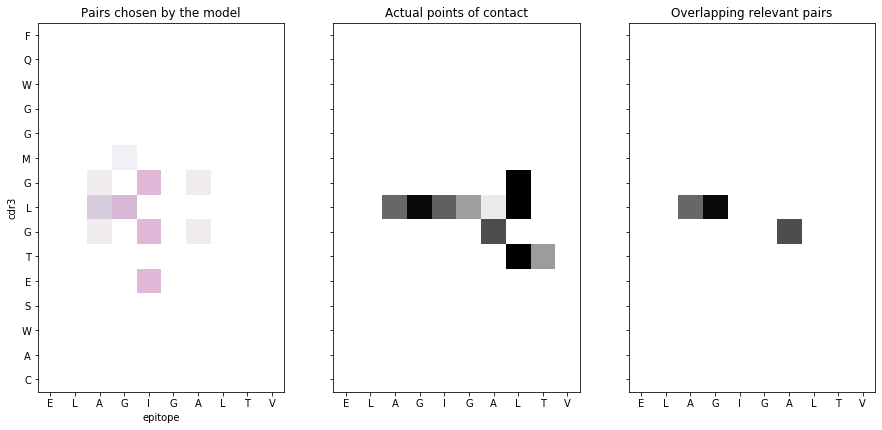

4JFF_C-E.txt


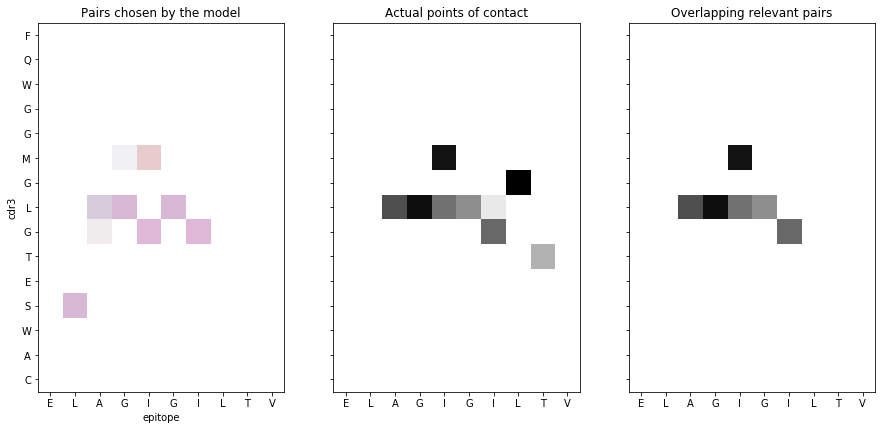

4L3E_C-E.txt


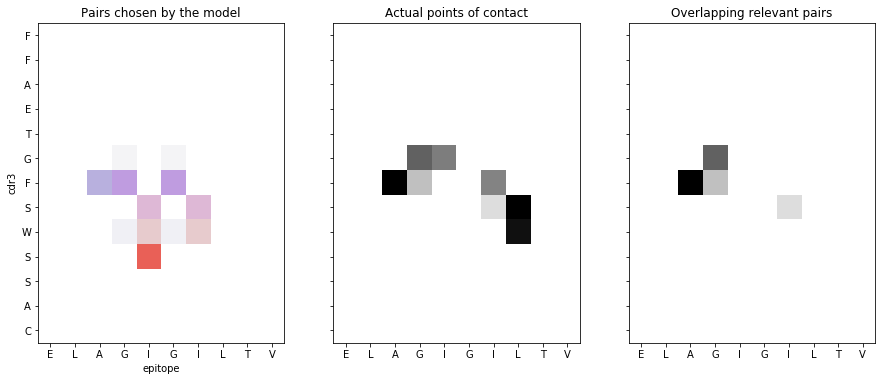

4MJI_C-E.txt


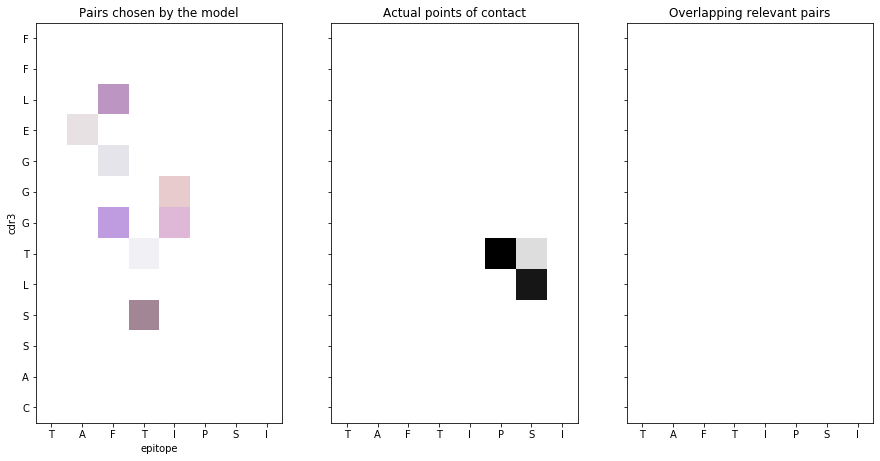

4MNQ_C-E.txt


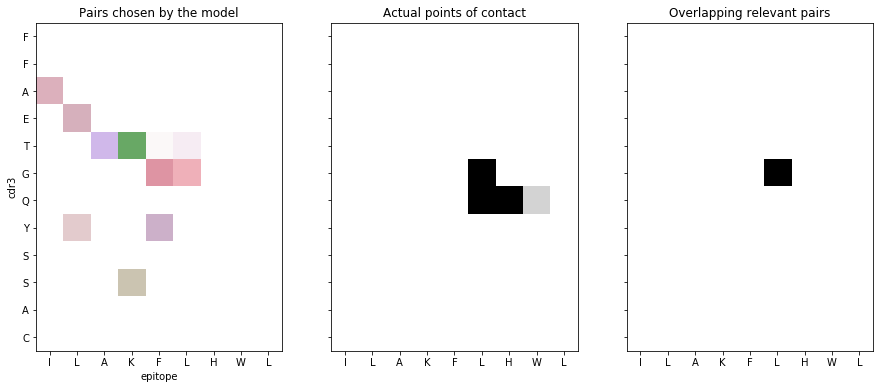

4PRH_C-E.txt


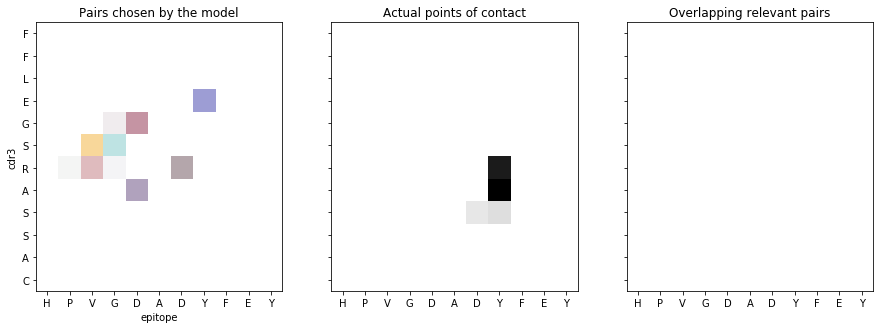

4PRI_C-E.txt


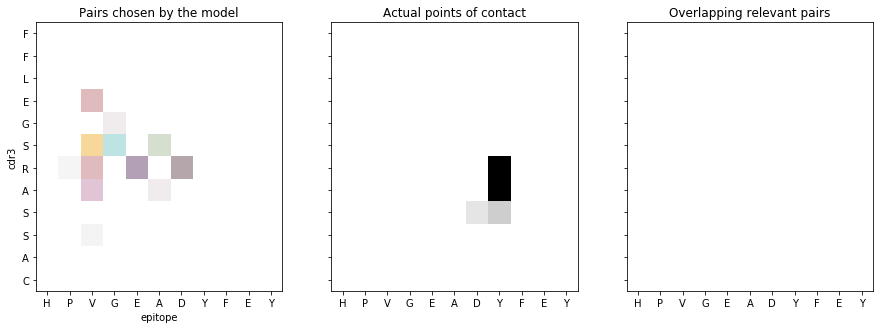

4PRP_C-E.txt


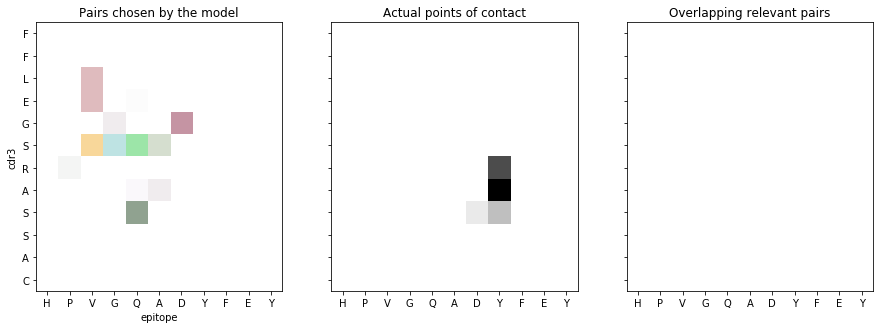

4QOK_C-E.txt


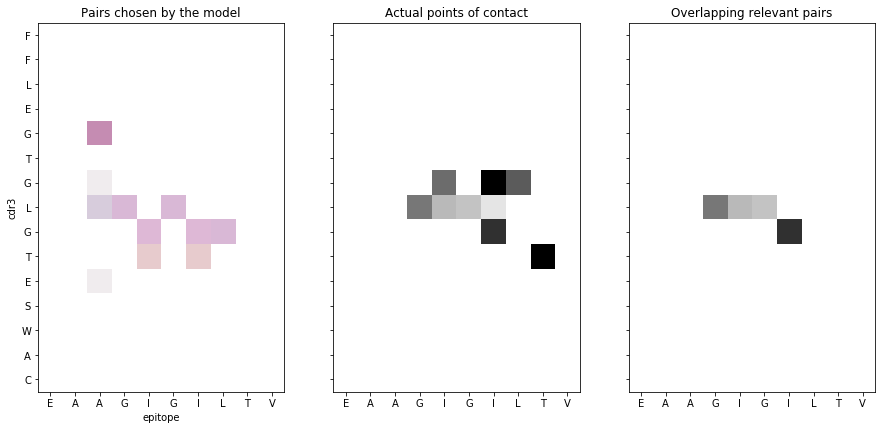

4QRP_C-E.txt


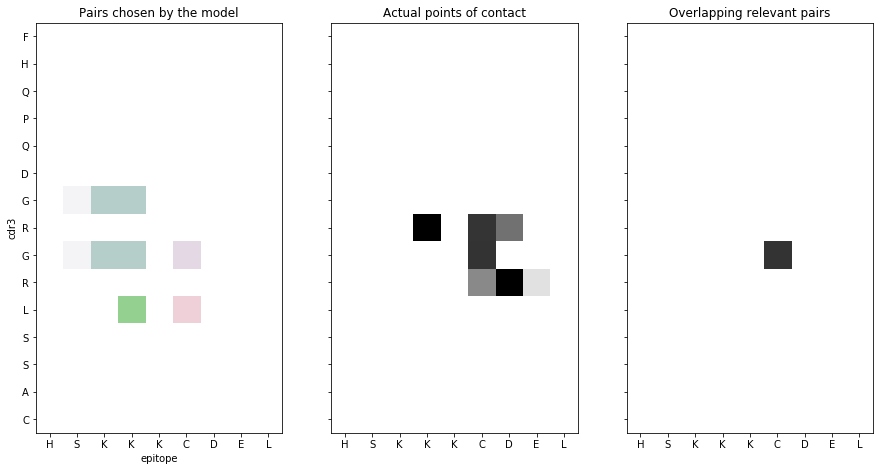

5BRZ_C-E.txt


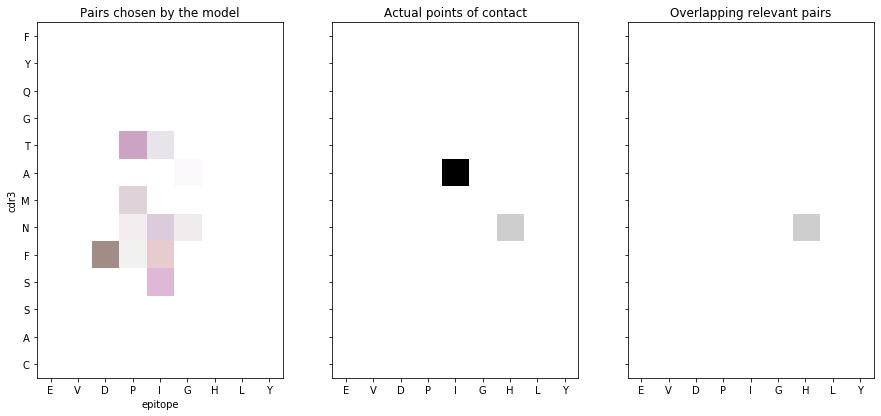

5BS0_C-E.txt


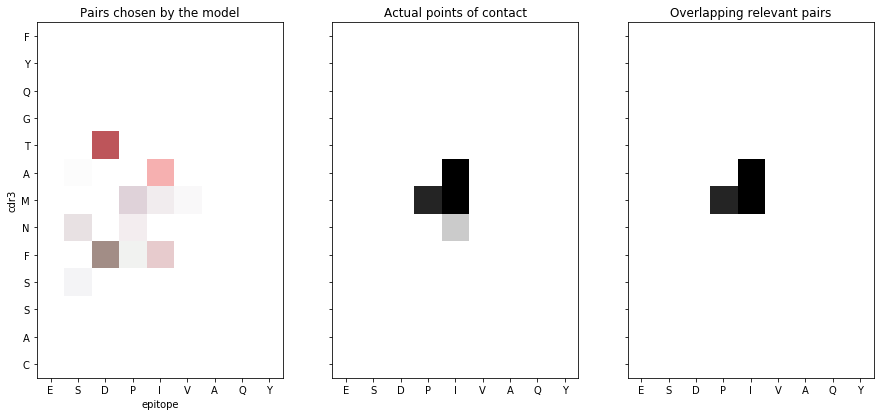

5C07_C-E.txt


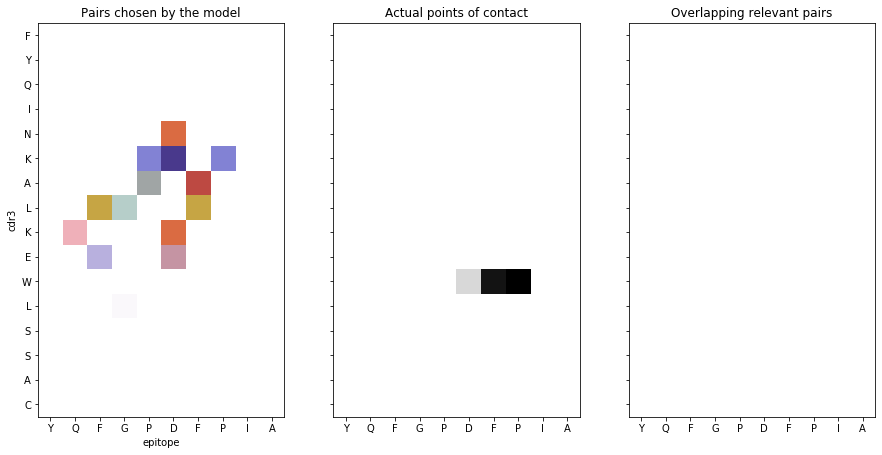

5C08_C-E.txt


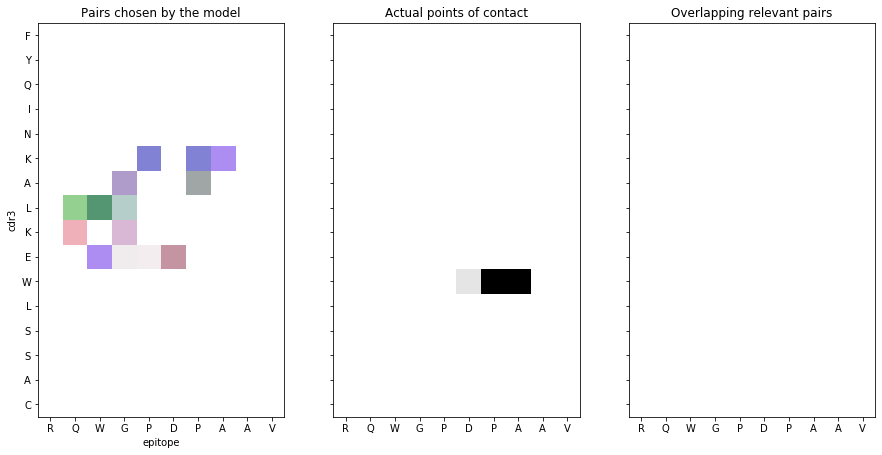

5C09_C-E.txt


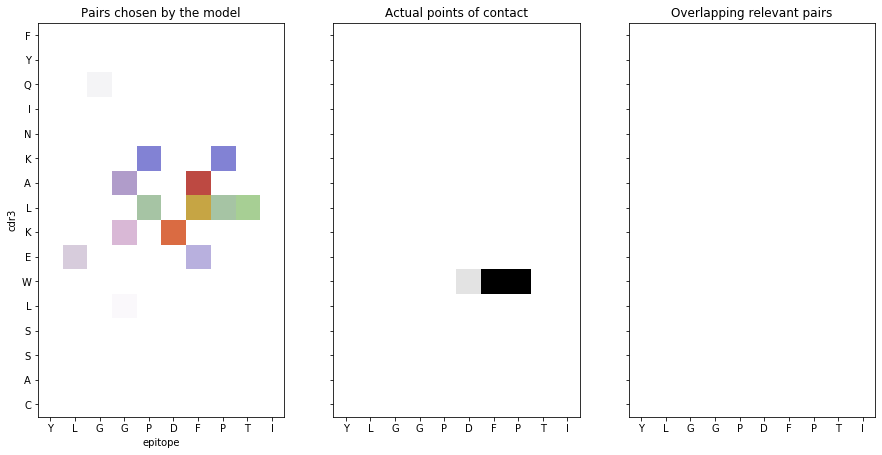

5C0A_C-E.txt


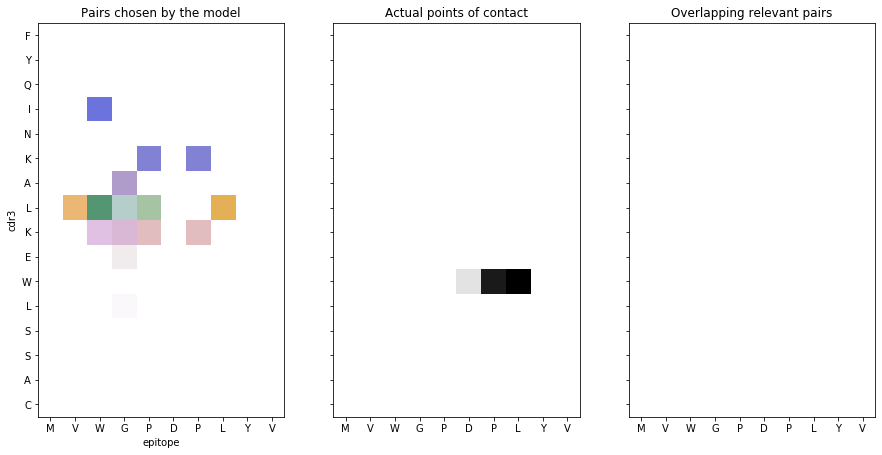

5C0B_C-E.txt


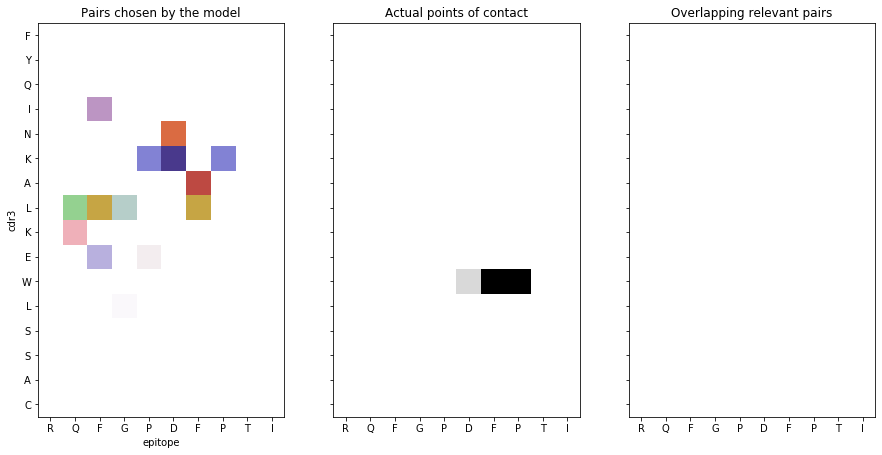

5C0C_C-J.txt


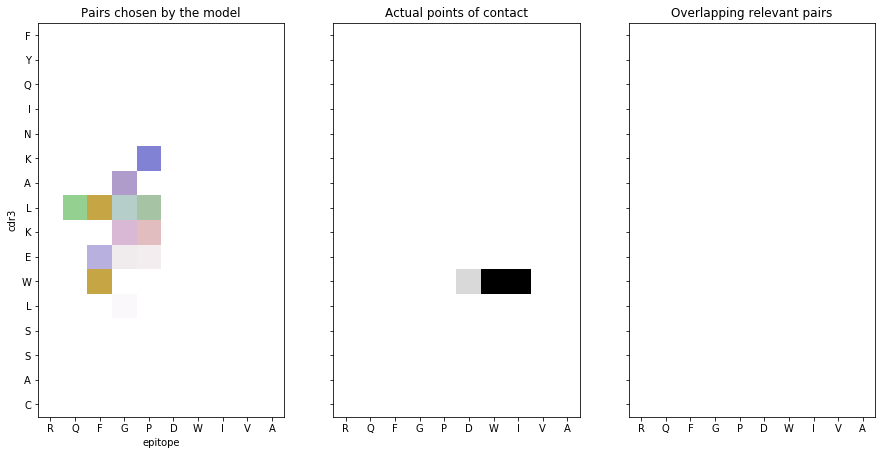

5E9D_C-E.txt


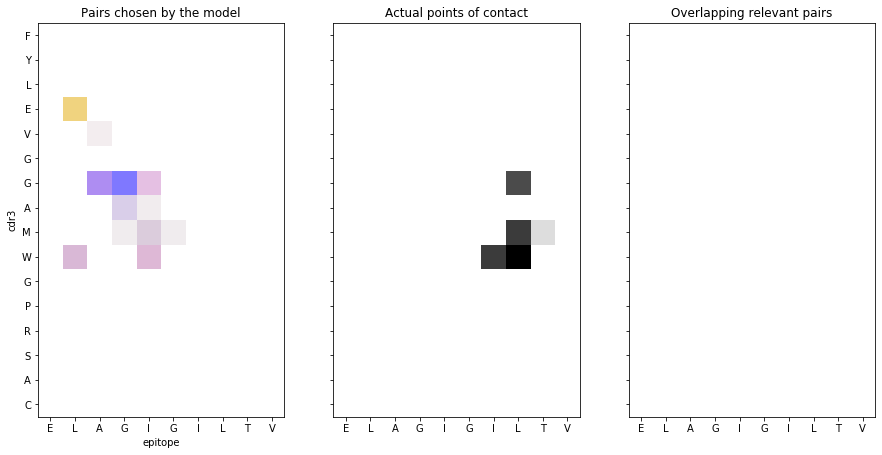

5EU6_C-E.txt


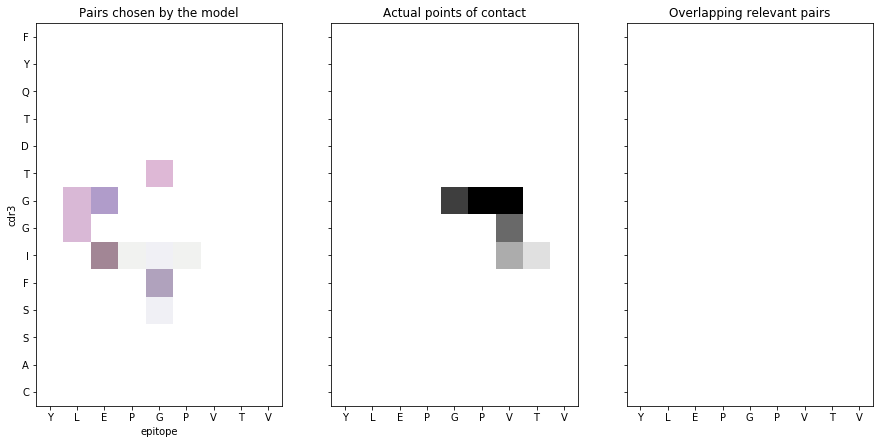

5HHM_C-E.txt


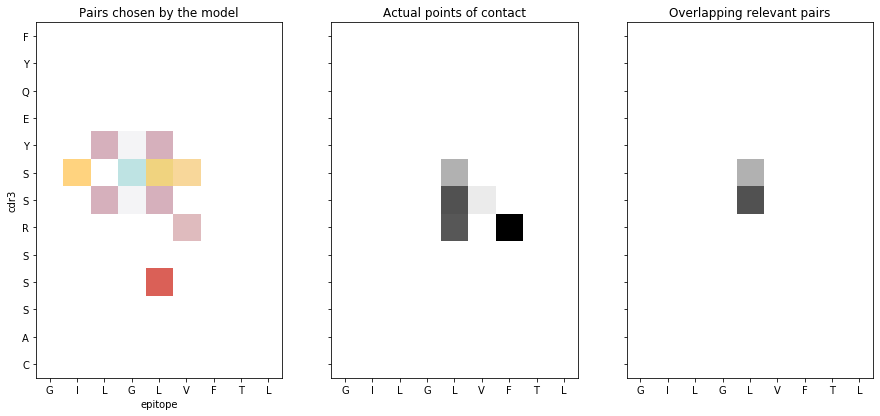

5HYJ_C-E.txt


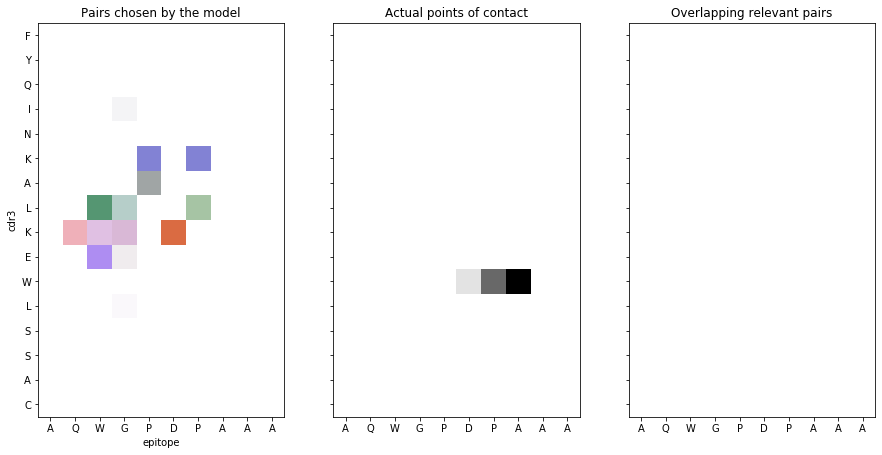

5ISZ_C-E.txt


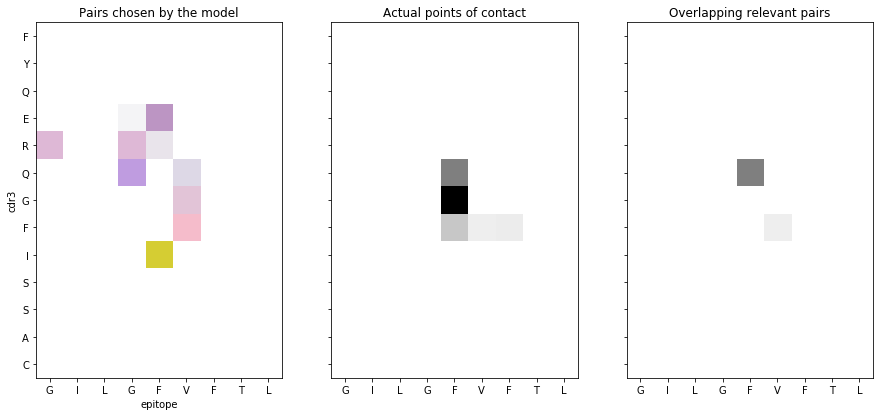

5JHD_C-E.txt


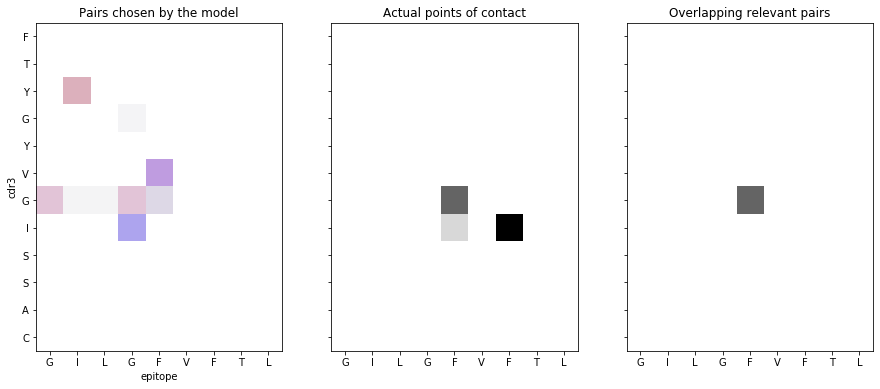

5JZI_C-E.txt


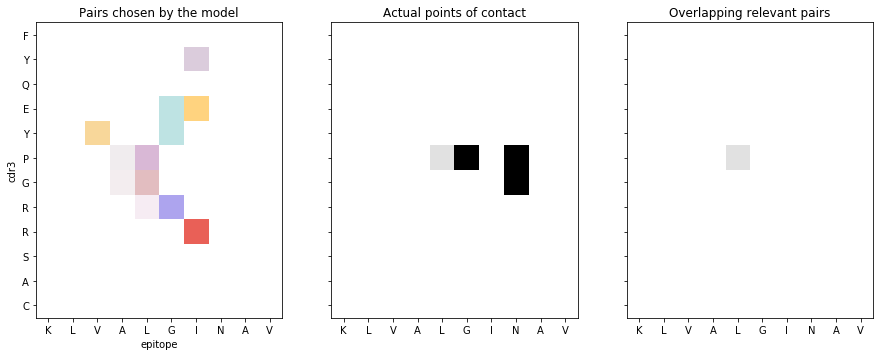

5MEN_C-E.txt


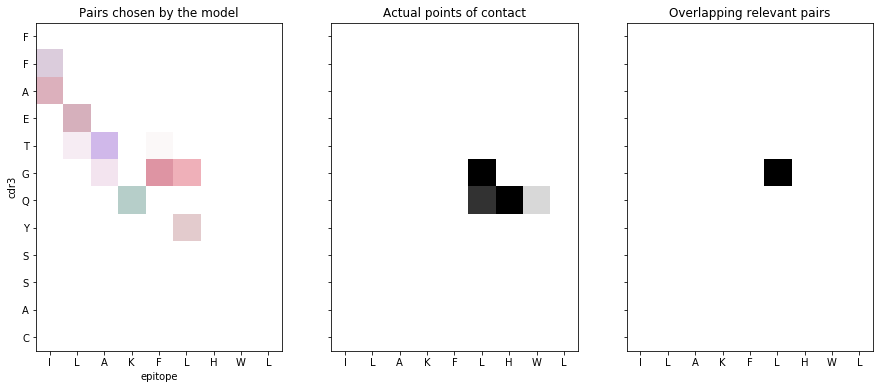

5NHT_P-B.txt


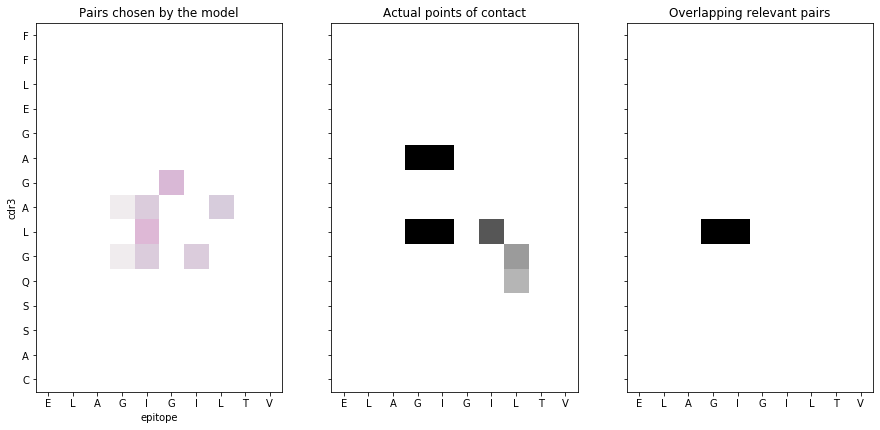

5NME_C-E.txt


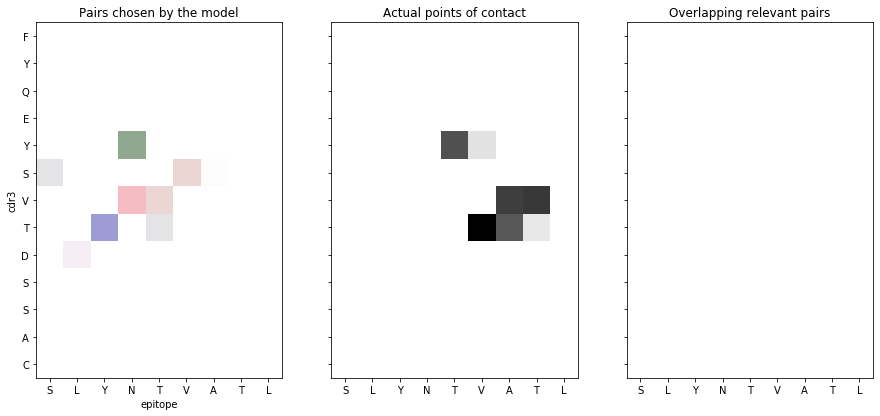

5NMF_C-E.txt


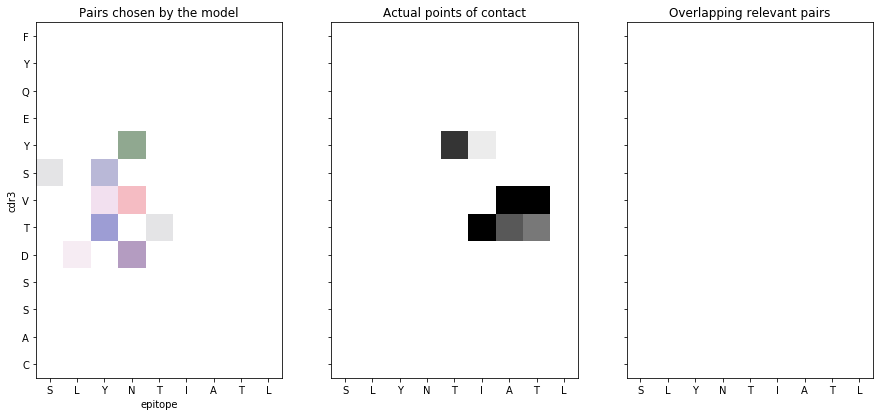

5NMG_C-E.txt


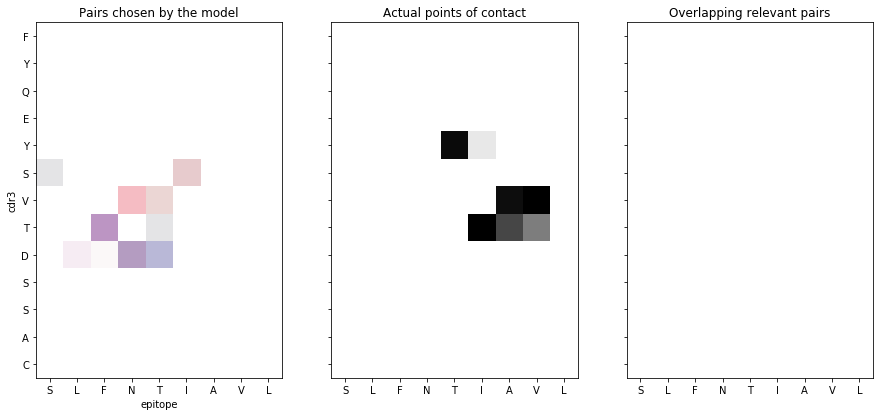

5NQK_P-B.txt


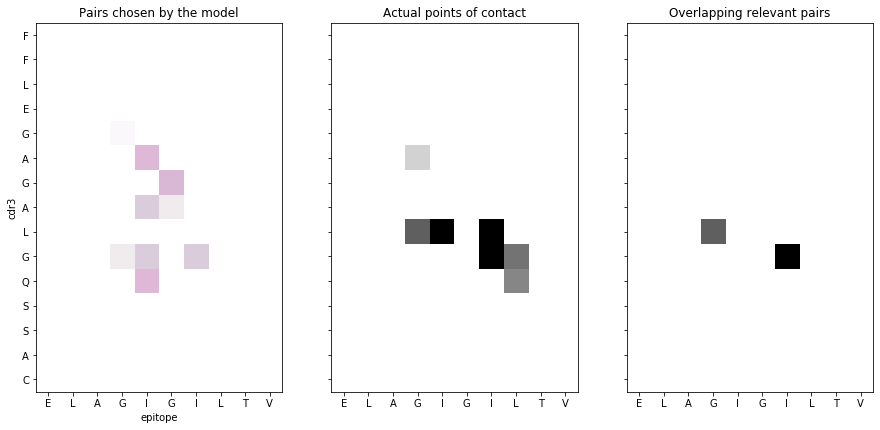

5TEZ_C-J.txt


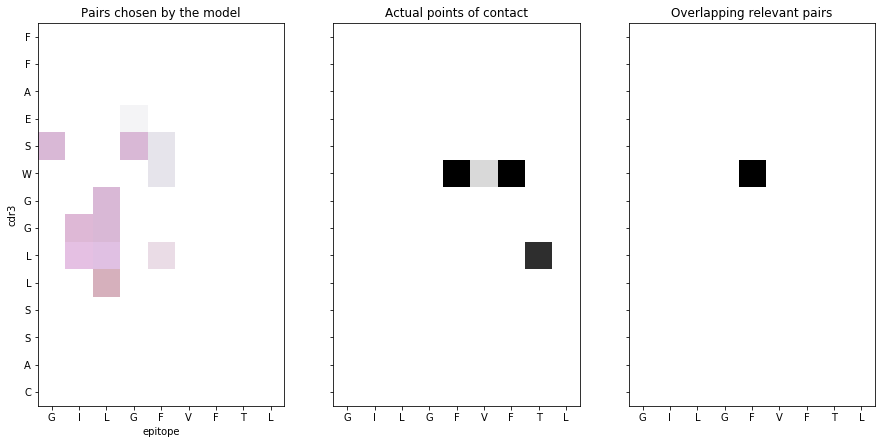

5WKF_C-E.txt


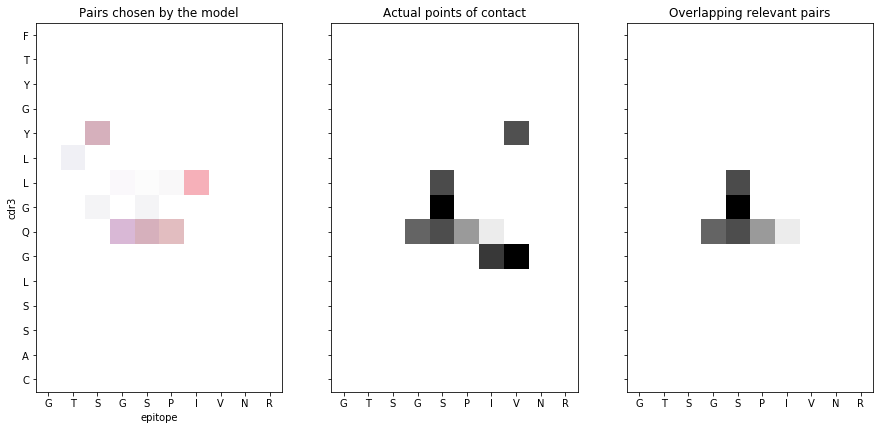

5WKH_C-E.txt


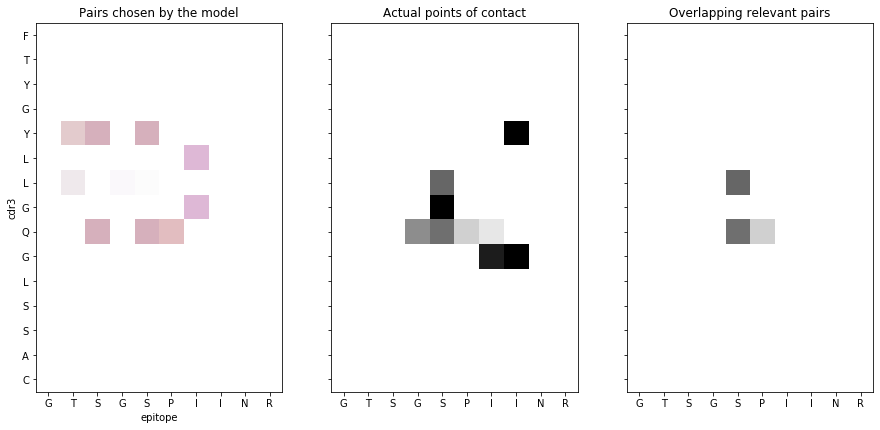

5XOT_C-E.txt


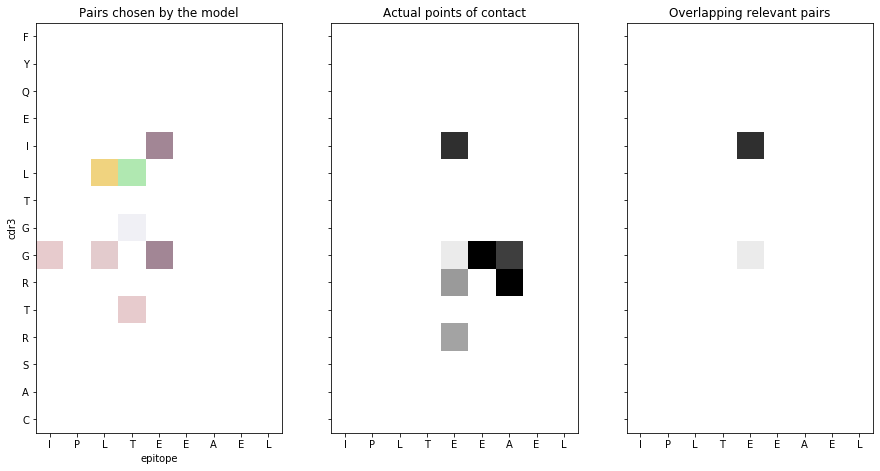

5XOV_C-J.txt


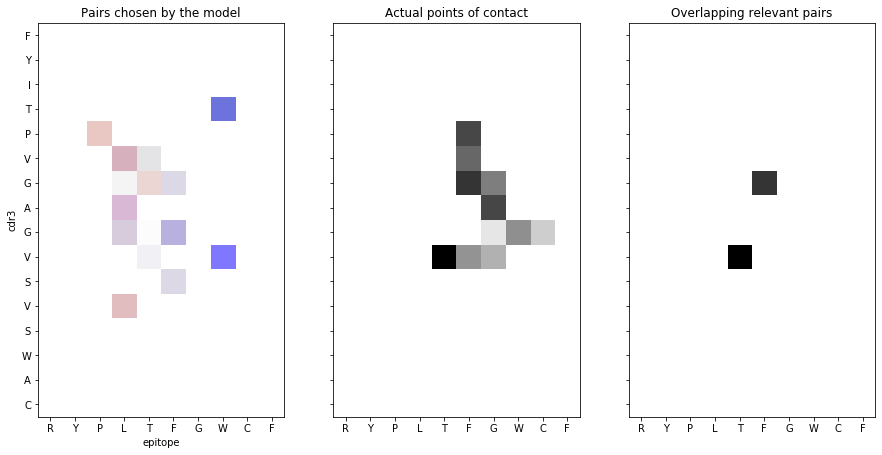

6AM5_C-E.txt


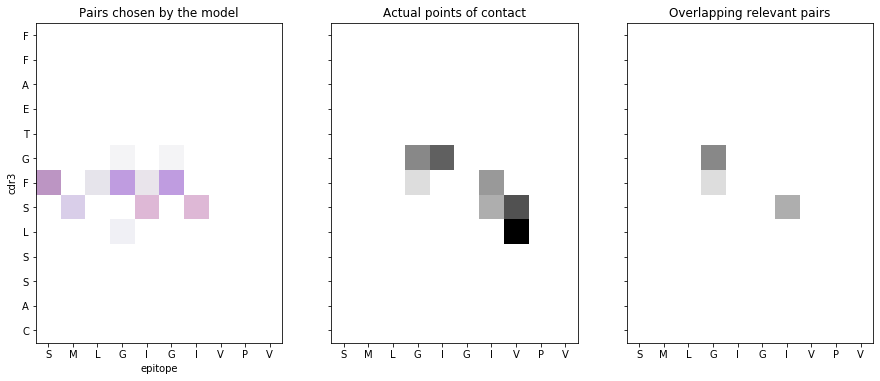

6AMU_C-E.txt


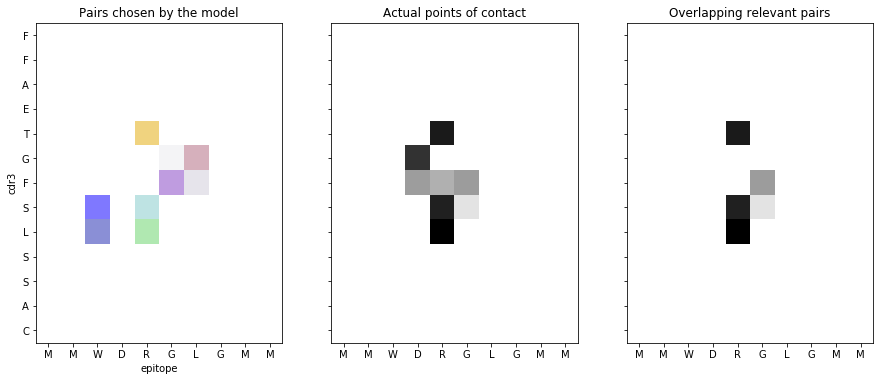

6DKP_C-E.txt


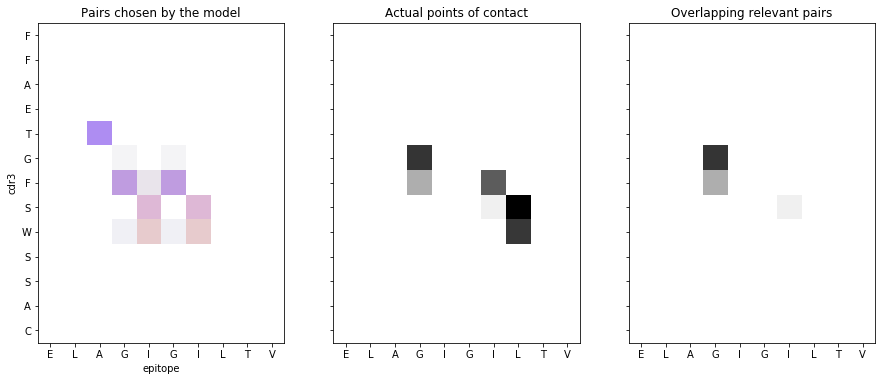

6MTM_C-E.txt


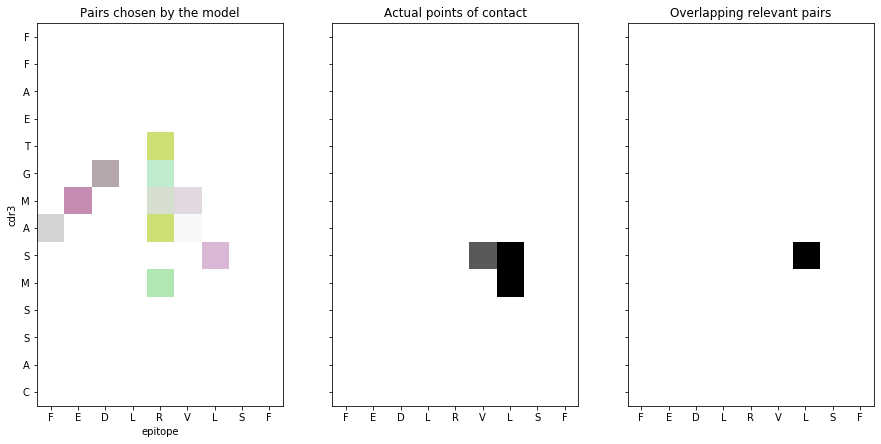

6Q3S_C-E.txt


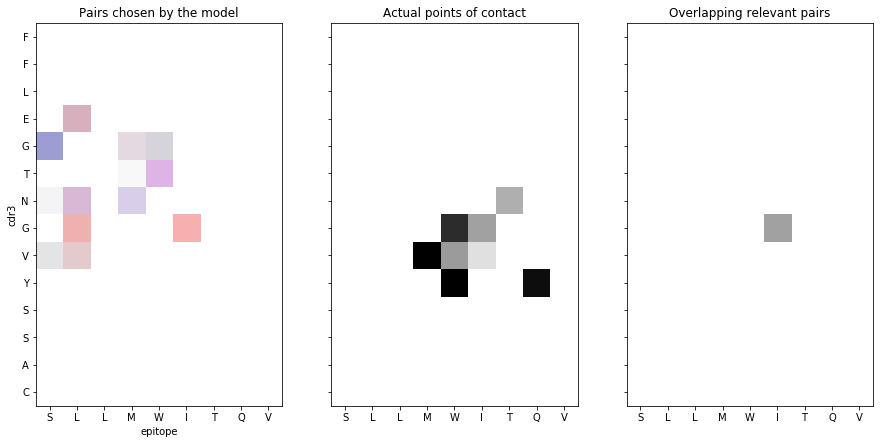

In [56]:
obs = []
exp = []
data_3D = [] 


baseline = tf.zeros(shape=(20,11,4))
integrated_gradients = saliency.IntegratedGradients()
ratio = 90 # percentile above which to choose the pixels


for i, comp in comps.iterrows():
    
    # load contact txt file
    contacts = pd.read_csv('./contacts/' + str(comp['contact_file']), delimiter = "\t")
    print(str(comp['contact_file']))
    # convert mappings
    contacts.replace({"ResNum2": mappings[i]}, inplace = True)
    contacts['ResNum2'] = (contacts['ResNum2'] - comp['CDR3_start']).astype('int32')
    contacts['ResNum1'] = (contacts['ResNum1'] - 1).astype('int32')
    
    best = pd.DataFrame({'Res1': contacts['Res2'].tolist(),
                         'Res2': contacts['Res1'].tolist(),
                         'Off1': contacts['ResNum2'].tolist(),
                         'Off2': contacts['ResNum1'].tolist(),
                        'Distance': contacts['Distance'].tolist()}).sort_values(by='Distance')
    
    # extract relevant pairs
    im = analysis_3D[i]
    

    # IG
    #vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)
    # SmoothGrad
    vanilla_integrated_gradients_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

    
    
    # Call the visualization methods to convert the 3D tensor to 2D grayscale
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    

    im_mask = np.array(im)

    mask = (im_mask != 0.0).all(axis=(2))
    im_mask = im_mask[(mask == True).any(axis=1),:]
    im_mask = im_mask[:,(mask == True).any(axis=0)]

    vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
    vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]

    r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, ratio)
    
    data_3D = extract_pairs(r_mask, vanilla_mask_grayscale, im_mask,
                              comps['cdr3'][i], comps['antigen.epitope'][i])
    data_3D = pd.DataFrame(data_3D)
    cdr3 = data_3D['cdr3'][0]
    epitope = data_3D['epitope'][0] 
    #print(cdr3,epitope)
    data_3D.drop(columns = ['cdr3', 'epitope', 'gray_value', 'property1', 'property2', 'property3', 'property4'], inplace = True)
    #print(data_3D)
    
    # remove negative values
    best.drop(best[best['Off1'] < 0.0].index, inplace=True)
    best.drop(best[best['Off2'] < 0.0].index, inplace=True)
    # remove 'HOH' value
    best.drop(best[best['Res1'] == 'HOH'].index, inplace=True)
    best.drop(best[best['Res2'] == 'HOH'].index, inplace=True)
    best.drop(best[best['Res2'] == '3IB'].index, inplace=True)
    
    # drop rows that have offsets that escape the sequences
    best.drop(best[best['Off1'] > len(cdr3)].index, inplace=True)
    best.drop(best[best['Off2'] > len(epitope)].index, inplace=True)
    
    best.drop_duplicates(subset=['Res1','Res2','Off1','Off2'],inplace = True)
    best.reset_index(drop=True, inplace=True)
    #print(best)
    
    found = pd.merge(data_3D, best, on=['Res1','Res2','Off1','Off2'])
    #print(found)
    
    
    contact_mask = np.zeros(r_mask.shape)
    found_mask = np.zeros(r_mask.shape) 
    for i,el in best.iterrows():
        contact_mask[-el['Off1']-1,el['Off2']] = el['Distance']+0.1
    for i,el in found.iterrows():
        found_mask[-el['Off1']-1,el['Off2']] = el['Distance']+0.1
        
    ################ save the number of pixels expected to be found by a random extraction and those observed
    exp.append(round(best.shape[0]*(1 - ratio/100), 2))
    obs.append(found.shape[0])
    ################round(a, 2)
          
    max_image = max(best['Distance']) # max and min values to reduce the distances into grayscale form
    min_image = min(best['Distance'])
    fig,(ax, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
    
    im_mask[~r_mask] = 0
    img = ax.imshow(im_mask)
    
    img2 = ax2.imshow(1-(contact_mask-min_image)/(max_image-min_image), cmap=P.cm.gray, vmin=0, vmax=1)
    img3 = ax3.imshow(1-(found_mask-min_image)/(max_image-min_image), cmap=P.cm.gray, vmin=0, vmax=1)


    ax.set_xticks(np.arange(len(epitope)))
    ax.set_yticks(np.arange(len(cdr3)))
    ax.set_yticklabels(cdr3[::-1])
    ax.set_ylabel('cdr3')
    ax.set_xlabel('epitope')
    ax.set_xticklabels(epitope)
    ax.set_title("Pairs chosen by the model")
    ax2.set_title("Actual points of contact")
    ax3.set_title("Overlapping relevant pairs")

    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.show()

In [57]:
scipy.stats.ttest_ind(obs, exp) # ttest to identify if there's a significative difference between the means
                                # of the observed number of overlapping pixels and the expected value if the
                                # extraction was randomic.

Ttest_indResult(statistic=4.946167921370022, pvalue=1.7738099320789882e-06)

In [58]:
print(obs)
print(exp)

[2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 3, 2, 1, 2, 1, 2, 3, 1, 0, 1, 0, 2, 1, 4, 0, 7, 1, 0, 0, 0, 0, 1, 0, 4, 2, 3, 4, 0, 0, 0, 0, 4, 2, 0, 2, 2, 5, 3, 6, 4, 0, 1, 0, 0, 0, 4, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 0, 0, 2, 1, 6, 3, 2, 2, 3, 5, 3, 1, 1]
[0.8, 0.8, 0.5, 0.4, 0.8, 0.7, 0.2, 0.9, 0.9, 0.5, 1.0, 0.8, 0.8, 0.9, 0.8, 0.8, 0.8, 0.3, 0.2, 0.2, 0.3, 0.8, 0.4, 0.7, 0.7, 1.1, 0.6, 0.6, 0.4, 0.4, 0.4, 0.8, 0.5, 0.8, 0.7, 1.2, 1.2, 0.6, 0.5, 0.3, 0.3, 0.9, 0.9, 1.0, 0.7, 0.8, 0.8, 1.0, 0.9, 0.8, 0.3, 0.4, 0.4, 0.4, 0.4, 0.9, 0.7, 0.2, 0.4, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.5, 0.6, 0.5, 0.3, 0.5, 0.3, 0.4, 0.4, 0.7, 0.7, 0.7, 0.7, 0.7, 0.4, 0.9, 0.9, 0.7, 1.1, 0.7, 0.8, 0.6, 0.3, 0.8]
